In [39]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import (NaiveSeasonal, 
                          NBEATSModel, 
                          ARIMA, 
                          TFTModel, 
                          RandomForest, 
                          ExponentialSmoothing, 
                          StatsForecastAutoARIMA)
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, stationarity_test_adf
from darts.metrics import smape
from statsmodels.tsa.seasonal import seasonal_decompose
from darts.utils.statistics import plot_residuals_analysis
from darts.dataprocessing.transformers import Scaler
import optuna
from pytorch_lightning.callbacks import EarlyStopping

# Helper Funcs

In [2]:
def plot_training_val(entire_series, pred, val, model_name = 'Model'):
    fig, (ax1, ax2) = plt.subplots(nrows = 2,ncols = 1, figsize = (12,8))
    entire_series.plot(label="actual", ax = ax1)
    pred.plot(label = 'prediction', ax = ax1, c = 'blue')
    ax1.set_title(f'Entire dataset with predicted values - {model_name}')
    val.plot(label = 'validation', ax = ax2)
    pred.plot(label = 'prediction', ax = ax2, c = 'blue')
    ax2.set_title(f'Actual sales with predicted values - {model_name}')
    fig.tight_layout()
    plt.show()

# Data Injestion

In [3]:
pkl_dir = Path(Path.cwd().parent, "data", "interim", "exploration_df.pkl")
df = pd.read_pickle(pkl_dir)

In [4]:
df = df.set_index('date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype    
---  ------      --------------   -----    
 0   store       913000 non-null  int64    
 1   item        913000 non-null  int64    
 2   sales       913000 non-null  int64    
 3   day         913000 non-null  int64    
 4   month       913000 non-null  int64    
 5   year        913000 non-null  int64    
 6   quarter     913000 non-null  int64    
 7   month_year  913000 non-null  period[M]
 8   month_name  120 non-null     object   
dtypes: int64(7), object(1), period[M](1)
memory usage: 69.7+ MB


In [5]:
df.head()

,store,item,sales,day,month,year,quarter,month_year,month_name
date,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,2013-01,Jan
2013-01-02,1,1,11,2,1,2013,1,2013-01,Feb
2013-01-03,1,1,14,3,1,2013,1,2013-01,Mar
2013-01-04,1,1,13,4,1,2013,1,2013-01,Apr
2013-01-05,1,1,10,5,1,2013,1,2013-01,May


# Creating a darts timeseries

In [6]:
series_group = TimeSeries.from_group_dataframe(df, 
                                group_cols = ['store', 'item'], 
                    time_col=None, 
                    value_cols='sales', 
                    static_cols=None, 
                    fill_missing_dates=False, 
                    freq='D', 
                    fillna_value=None)

In [7]:
len(series_group)
# one series for each store and product = 10* 50 = 500

500

# Testing first series

In [8]:
single_series = series_group[1] #store 1 item 1
single_series.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)>
array([[[33.]],

       [[43.]],

       [[23.]],

       [[18.]],

       [[34.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-05
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store  item\ncomponent            ...
    hierarchy:          None

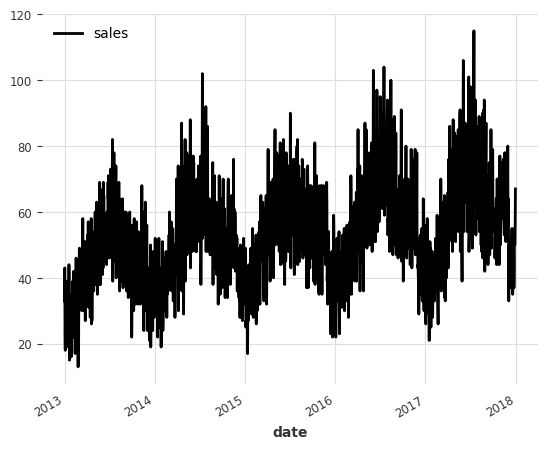

In [9]:
single_series.plot()

# Decomposition

In [10]:
single_df = df[(df['store'] == 1) & (df['item'] == 1)]

With statsmodels we can decompose the sales for a single store and item into seasonal and trend components. 

<Figure size 640x480 with 0 Axes>

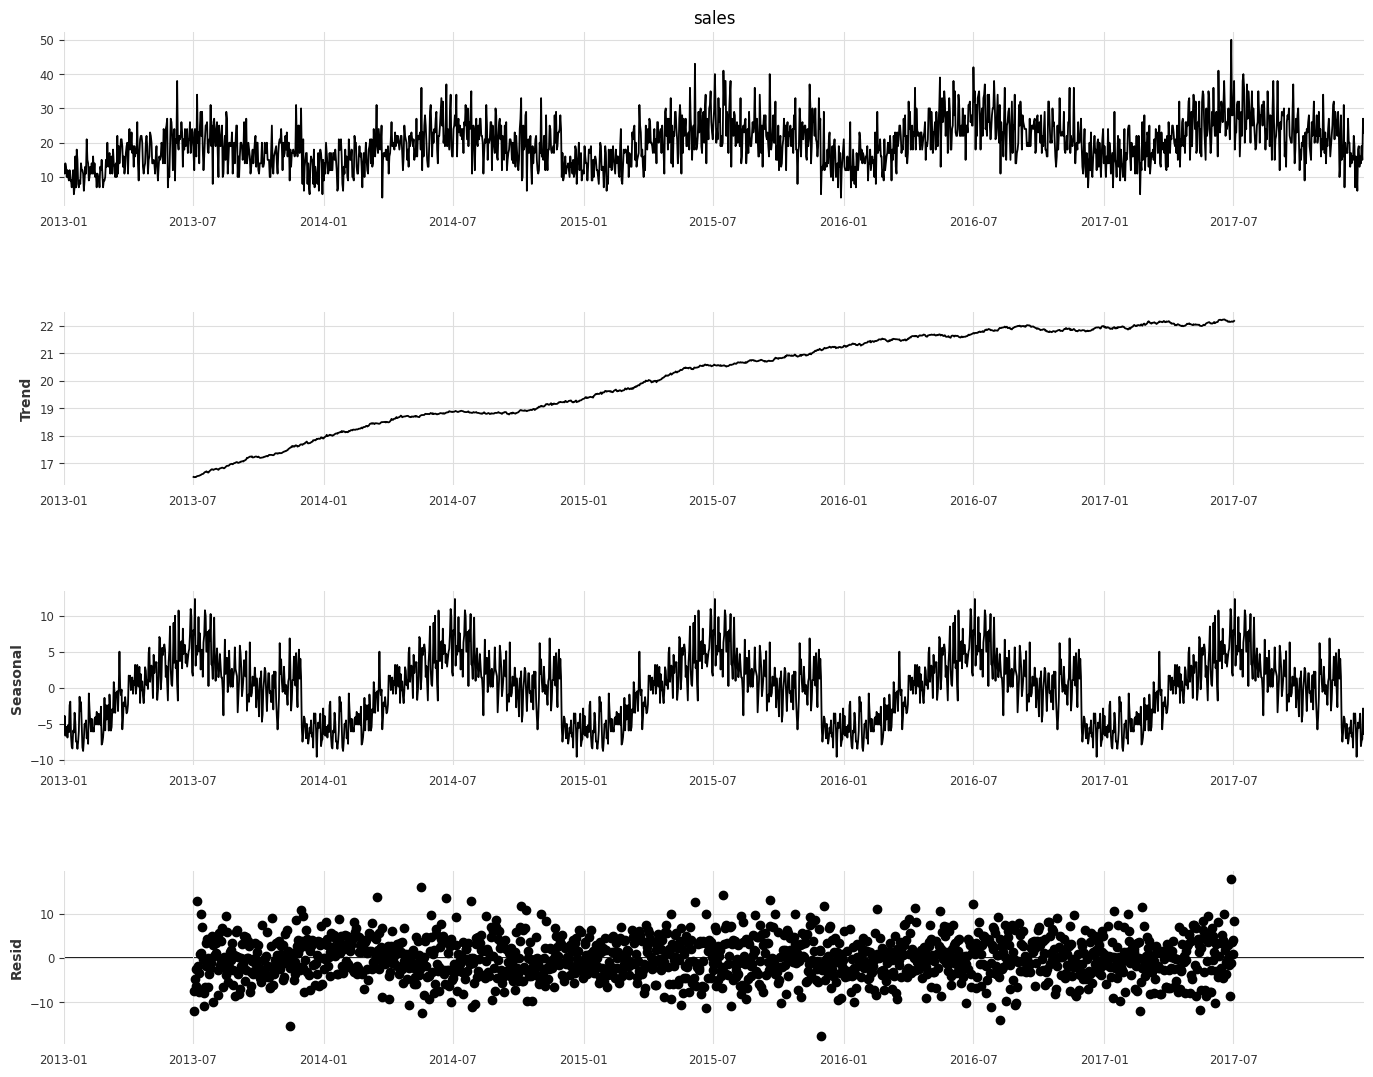

In [11]:
result = seasonal_decompose(single_df['sales'], model='additive', period = 365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

# ACF and PACF

We can test for seasonality by plotting the auto-correlation function (ACF). 
We can plot the ACF for the entire four years of data, highlighting the 1 year period. 

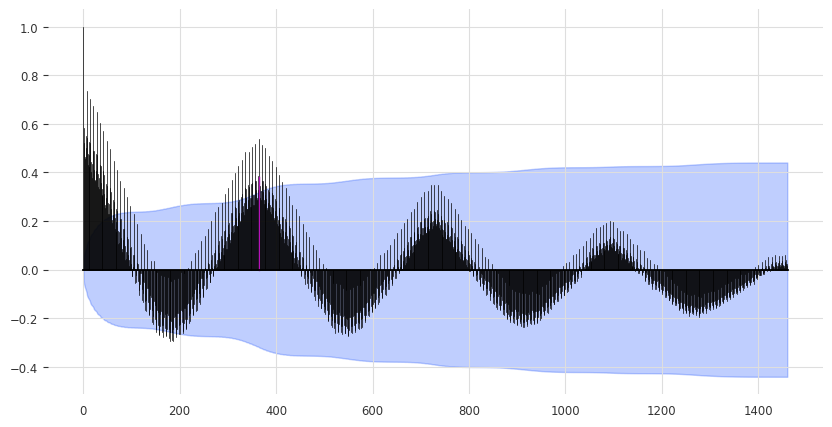

In [12]:
plot_acf(single_series, m = 365, max_lag = 365*4, alpha=0.05)

Based on the decaying ACF, we are likely dealing with an auto regressive model. 

For clarity, we can also inspect the first portion, as this seems to be the most highly correlated. 

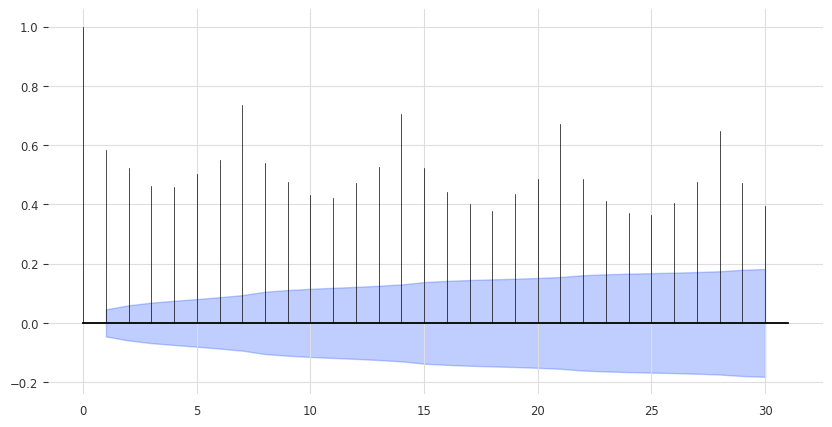

In [13]:
plot_acf(single_series, max_lag = 30, alpha=0.05)



Lets check the PACF for a year to see more concrete evidence. 

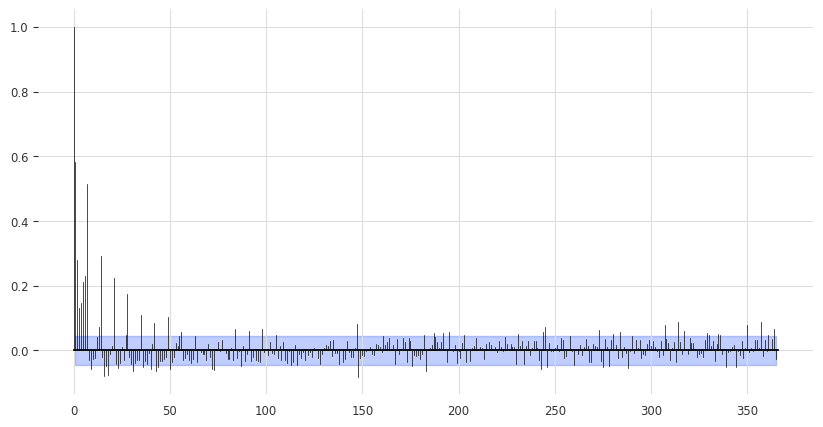

In [14]:
plot_pacf(single_series, max_lag = 365, alpha=0.05)

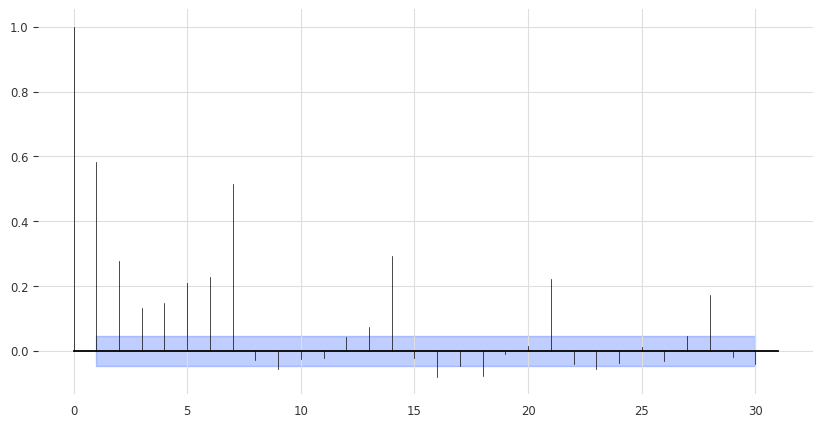

In [15]:
plot_pacf(single_series, max_lag = 30, alpha=0.05)

The blue zone in the above plots indicate statistical significance, and anything inside them can be considered statistically insignificant. 

We can ignore the correlation at point 0, as obviously the current time data is perfectly correlated with itself. 

Both the ACF and PACF indicate the strongest correlation at lag = 7, indicating a weekly trend. This can be confirmed with darts' check_seasonality function. 

In [16]:
check_seasonality(single_series)

(True, 7)

# Basic forecasting

Testing some naive forecasting methods. 
First we need to split intro train/test.

## Train test split

In [17]:
train, val = single_series.split_after(0.75)
len(train), len(val)

(1369, 457)

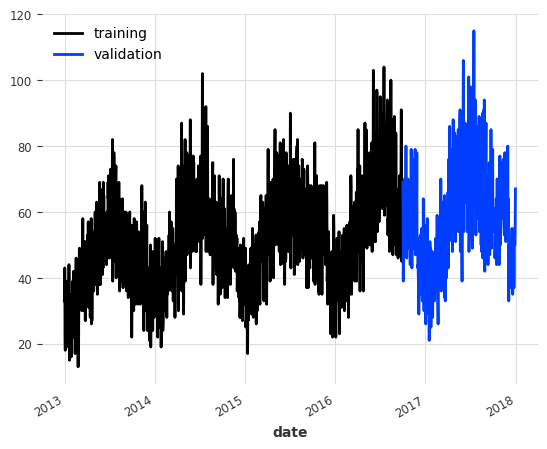

In [18]:
train.plot(label="training")
val.plot(label="validation")

Lets create a dict to hold all of our results for the different models for easy comparison

In [19]:
results_dict = {}

First we'll test a naive seasonal model. 
This is useful to get an idea of the bare minimum accuracy that one could expect. For example, the NaiveSeasonal(K) model always “repeats” the value that occured K time steps ago.

In its most naive form, when K=1, this model simply always repeats the last value of the training series:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


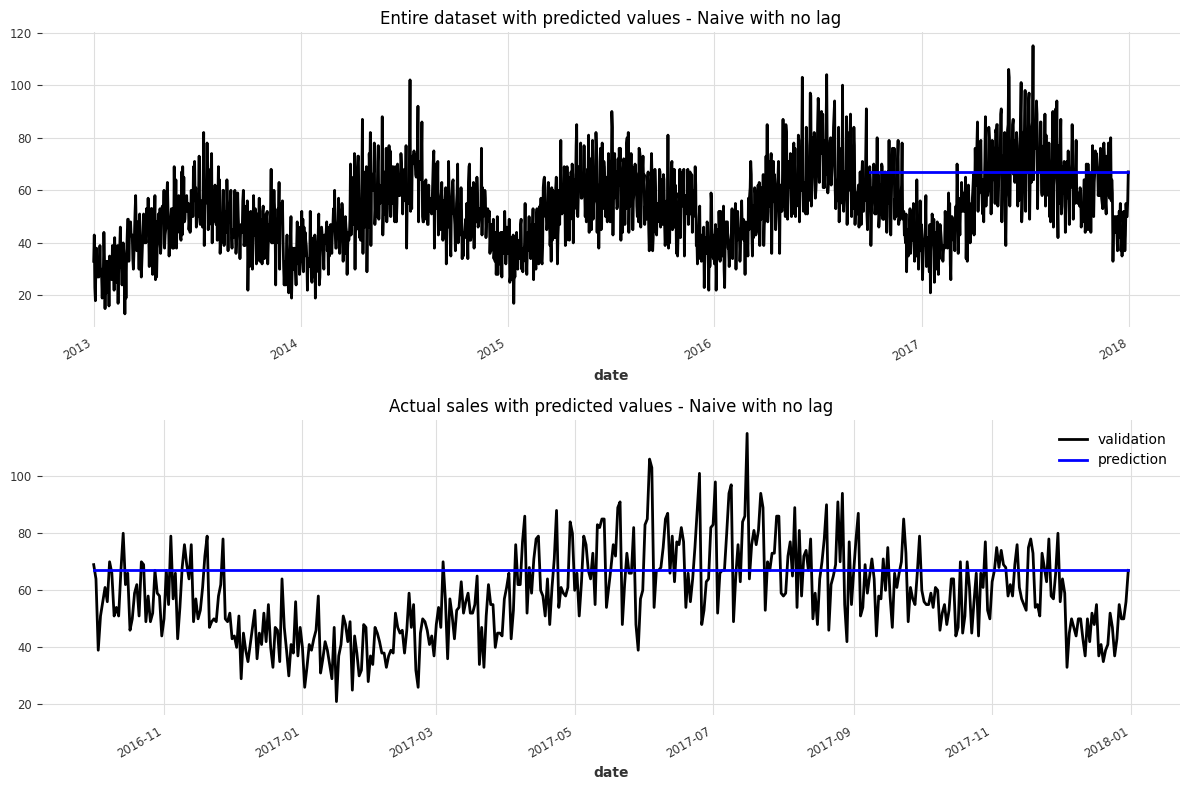

In [20]:
LAG = 1
seasonal_model = NaiveSeasonal(K=LAG) #Based on the acf results above
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = seasonal_forecast, 
                  val = val, 
                  model_name = "Naive with no lag")

For this basic model I'm going to use symmetric Mean Absolute Percentage Error (SMAPE), as this is the metric used in the original kaggle competition. 

In [21]:
print(f"The SMAPE assosciated with the naive seasonal model with no lag is: {smape(single_series, seasonal_forecast):.2f}")
results_dict['naive_no_lag'] = smape(single_series, seasonal_forecast)

The SMAPE assosciated with the naive seasonal model with no lag is: 24.73


Let's try another seasonal naive model using the 7 day lag we identified in the acf and pacf, multiplied out to capture more of the trend. 

I'm going to use 364 days for the lag, as this should capture the entire yearly trend whilst being divisable by our acf/pacf lag identified. 

Using just a 7 day lag when trying to predict over 450 days is not going to cut it. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


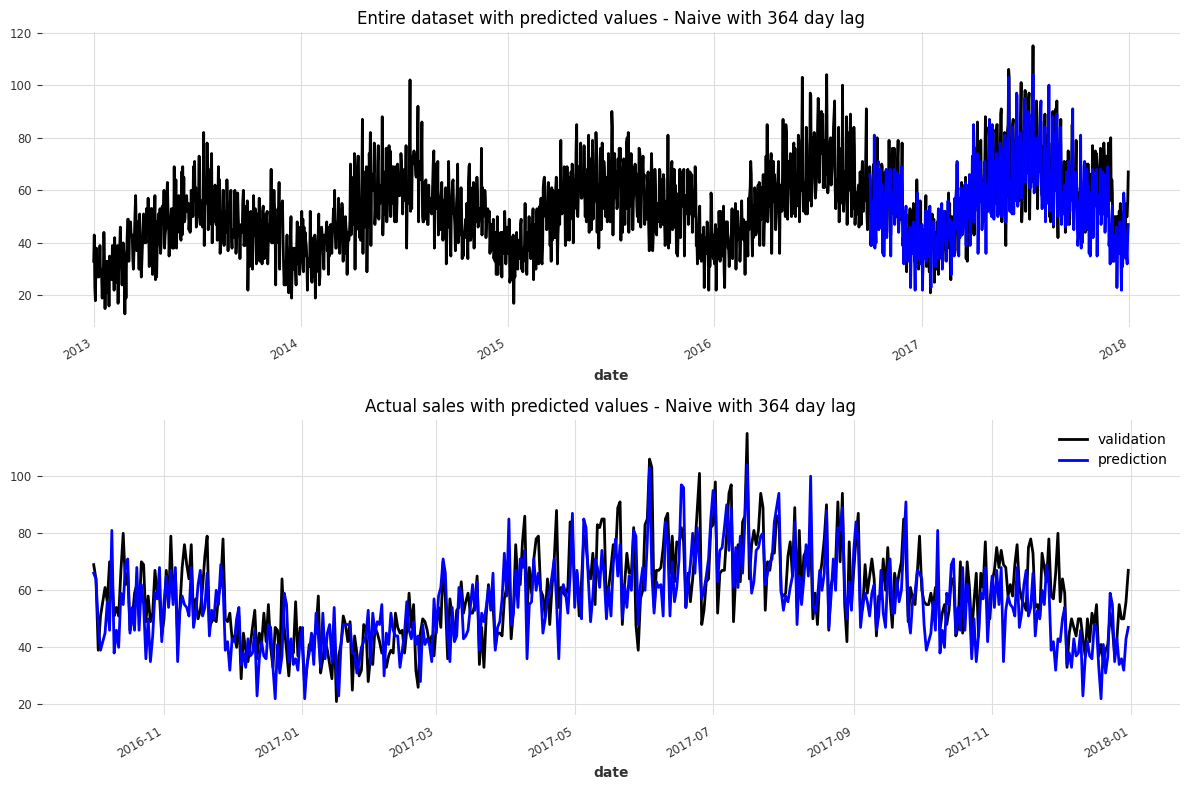

The SMAPE assosciated with the naive seasonal model is: 16.48


In [22]:
LAG = 364
seasonal_model = NaiveSeasonal(K=LAG) #Based on the acf results above
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = seasonal_forecast, 
                  val = val, 
                  model_name = "Naive with 364 day lag")

print(f"The SMAPE assosciated with the naive seasonal model is: {smape(single_series, seasonal_forecast):.2f}")
results_dict['naive_364_lag'] = smape(single_series, seasonal_forecast)

SMAPE isnt too bad, and the model has generalized fairly well for such a simple model. Let's take a closer look at the val/pred portion. 

We can investigate residuals from the models with darts plot_residuals_analysis()

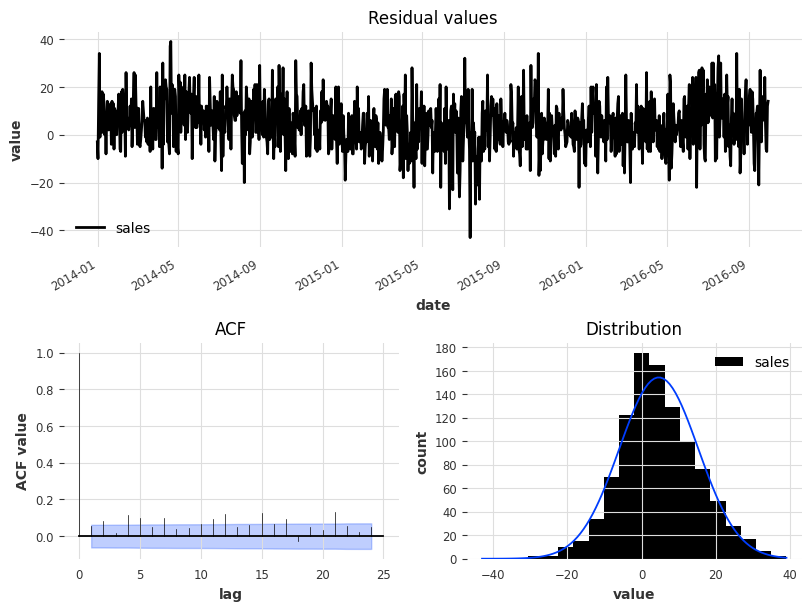

In [23]:
plot_residuals_analysis(seasonal_model.residuals(train))

These graphs show that the naïve method produces forecasts that appear to account for all available information. The mean of the residuals is close to zero and there is no significant correlation in the residuals series. 

 The time plot of the residuals shows that the variation of the residuals stays much the same across the historical data, apart from the one outlier, and therefore the residual variance can be treated as constant. This can also be seen on the histogram of the residuals. 

 

Lets try some more advanced models.

# SARIMA


As ARIMA models are only good for stationary data, we should check this first.
 Stationary means that the mean, standard deviation, and variance don't change over time. 

In [24]:
stationarity_test_adf(train)

(-2.5534995304095447,
 0.10299377129198278,
 21,
 1347,
 {'1%': -3.4352139981780865,
  '5%': -2.863688081179776,
  '10%': -2.567913641703717},
 9587.166273116578)

The function returns numerous results, but we are mostly interested in the second value (P-Test). Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can not be rejected. Hence, the series is non-stationary.


In [25]:
train_df = train.pd_dataframe()

Let's take the first difference and check for stationarity again. This calculates the difference between each row with the one before it. 

<AxesSubplot: xlabel='date'>

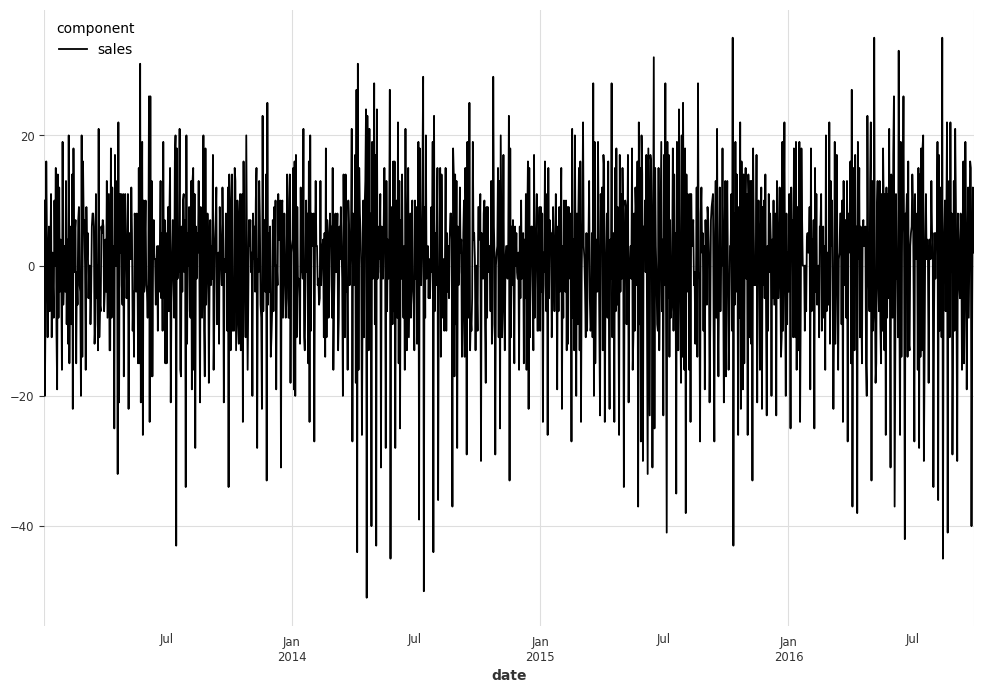

In [26]:
first_diff = train_df.diff()[1:]
fig, ax = plt.subplots(figsize = (12,8))
first_diff.plot(ax = ax)


Looks like the upwards trend has been removed, since taking the first difference seems to have made it stationary, we can try setting the *I* portion of the SARIMA model to 1. 
We can check both the stationarity and seasonality below. 


In [27]:
stationarity_test_adf(TimeSeries.from_dataframe(first_diff))

(-11.320401859532137,
 1.1780364927927875e-20,
 20,
 1347,
 {'1%': -3.4352139981780865,
  '5%': -2.863688081179776,
  '10%': -2.567913641703717},
 9585.541519440438)

Since the P-value is much lower than 0.05 we can assert the first difference is stationary. 

In [28]:
check_seasonality(TimeSeries.from_dataframe(first_diff))

(True, 2)

The first diff is still seasonal with periodicity 2. 

Next we can plot the ACF and PACF of this first different to get an idea of the values to use for SARIMA. 

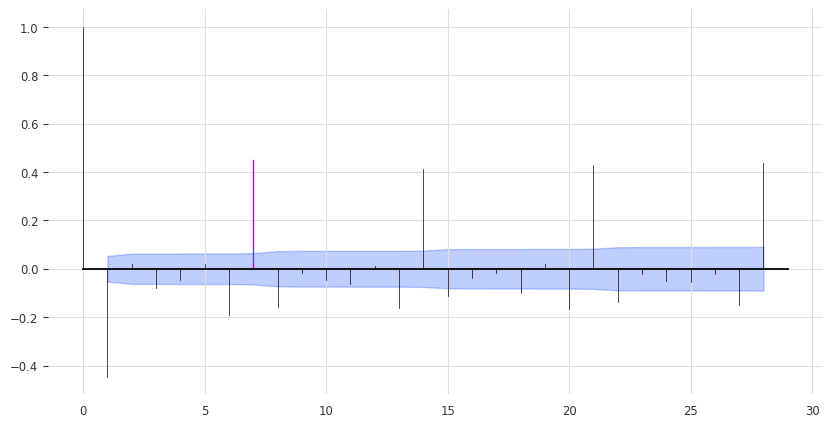

In [29]:
plot_acf(TimeSeries.from_dataframe(first_diff), m = 7, max_lag = 28)

Based on the ACF we should start with a seasonal MA process of 1. 

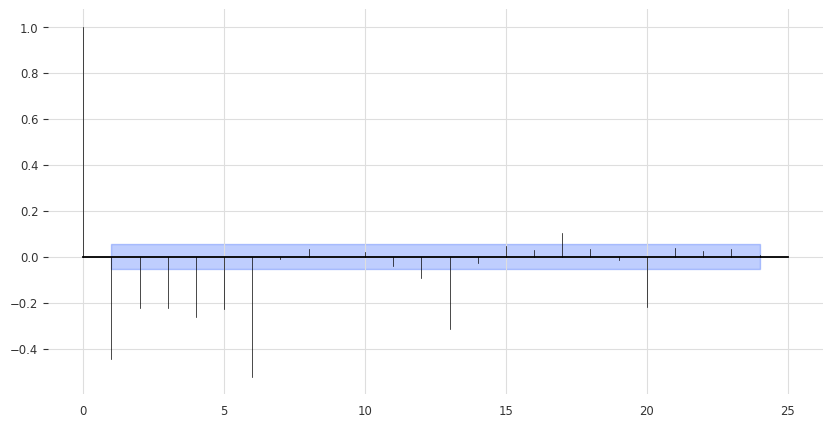

In [30]:
plot_pacf(TimeSeries.from_dataframe(first_diff))

Based on the PACF we should start with a seasonal AR process of value 6. 

We can test for stationarity with the stationarity_test_adf function. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


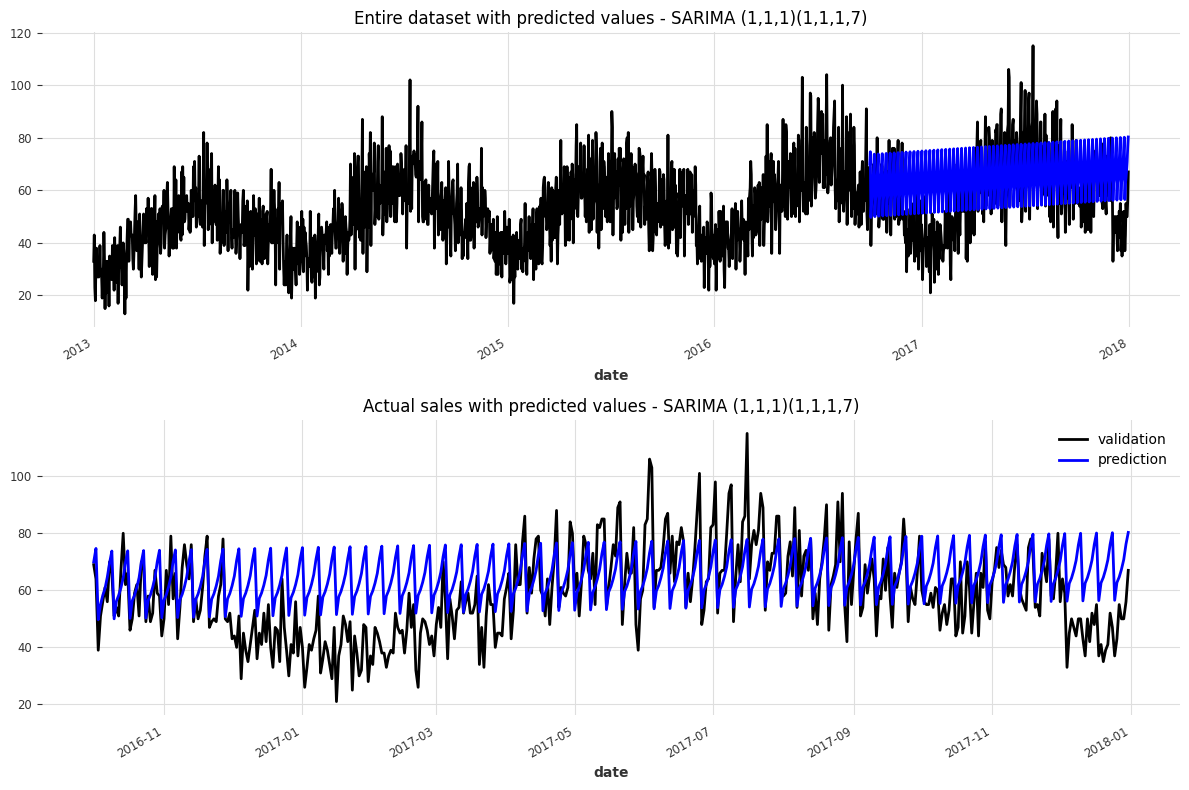

SMAPE for the ARMA model is : 20.48


In [44]:
p,d,q = 6,1,0
seasonal_order = (0,1,1,7)
model_aarima = ARIMA(p = p, d = d, q = q, seasonal_order = seasonal_order) 
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = prediction_aarima, 
                  val = val, 
                  model_name = "SARIMA (1,1,1)(1,1,1,7)")

print(f"SMAPE for the ARMA model is : \
{smape(single_series,prediction_aarima):.2f}")
results_dict['SARIMA'] = smape(single_series,prediction_aarima)

I have tried multiple different values for p,d,q and cant seem to find anything that works well.

The model doesnt seem to capture the entire seasonality. 
I've tried increasing the lag but this slows down the modelling exponentially. 

Let's see if an autoARIMA model can find some better params. 



# AutoARIMA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


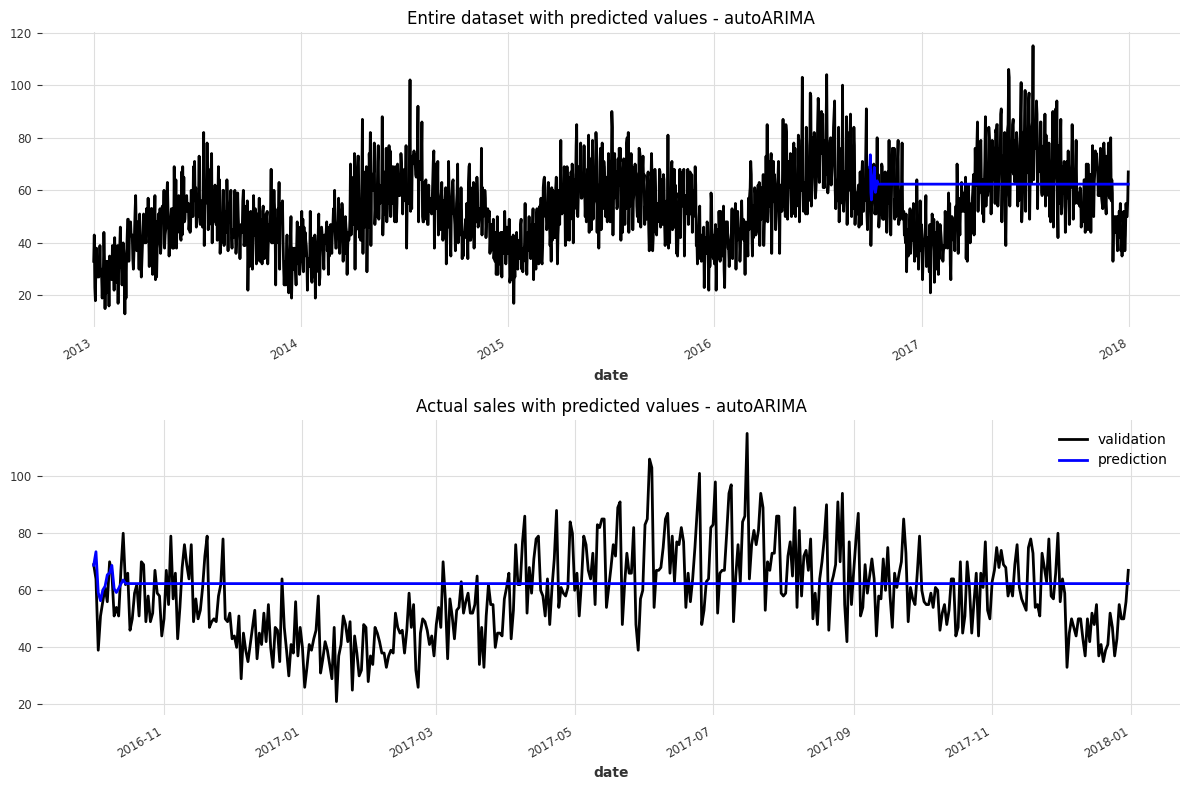

SMAPE for the autoARIMA model is : 22.37


In [43]:
model_aarima = StatsForecastAutoARIMA(season_length = 7)

model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = prediction_aarima, 
                  val = val, 
                  model_name = "autoARIMA")

print(f"SMAPE for the autoARIMA model is : \
{smape(single_series,prediction_aarima):.2f}")
results_dict['autoARIMA'] = smape(single_series,prediction_aarima)

Actually worse than my parameters! Going to move on to other forms of modelling for now. 

# Exponential smoothing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


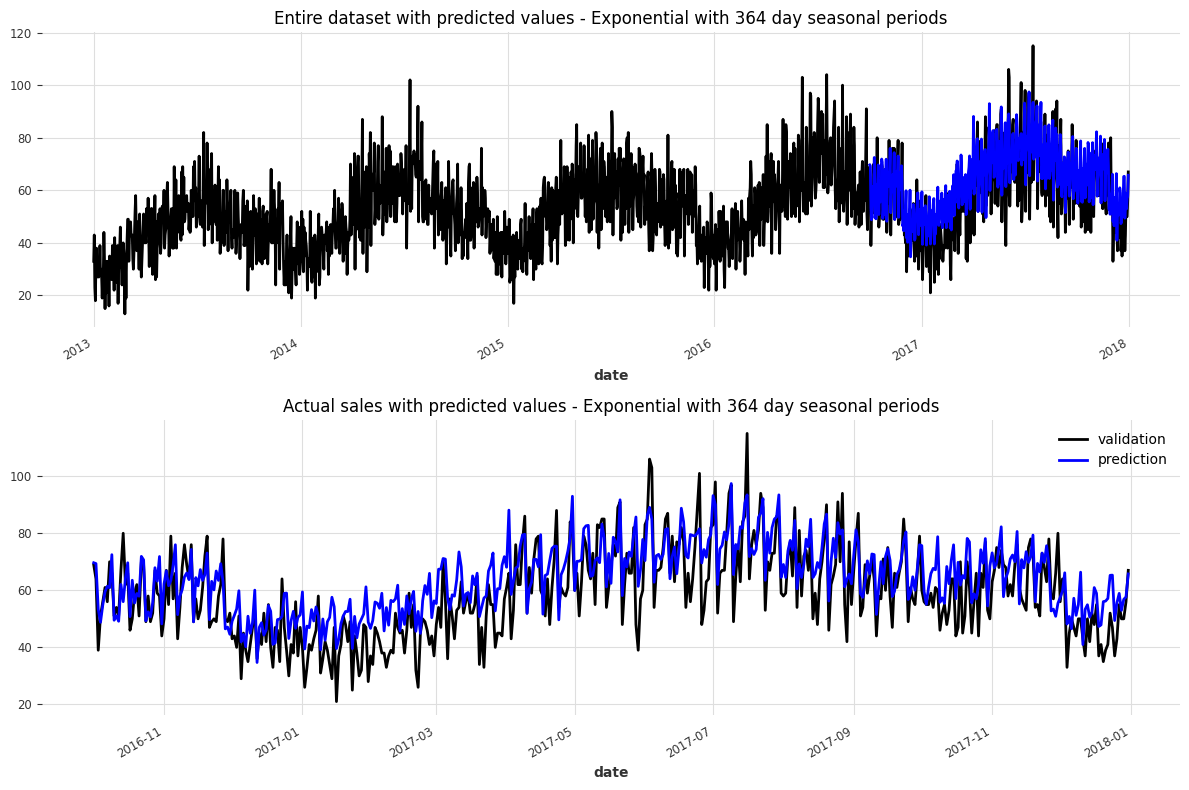

The mean squared error associated with the exponential smoothing model is: 15.48


In [46]:
model_es = ExponentialSmoothing(seasonal_periods=364)
model_es.fit(train)
es_forecast = model_es.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = es_forecast, 
                  val = val, 
                  model_name = "Exponential with 364 day seasonal periods")

print(f"The mean squared error associated with the exponential smoothing model is: {smape(single_series, es_forecast):.2f}")

results_dict['exponential_smoothing'] = smape(single_series, es_forecast)

Decent SMAPE score but has captured the trend better than ARIMA, is also much, much faster than arima when using higher lag values. 

# ML models

## Preprocessing

We need to scale the data between 0 and 1 for most ML algorithms to perform well. 

In [47]:
df.head()

,store,item,sales,day,month,year,quarter,month_year,month_name
date,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,2013-01,Jan
2013-01-02,1,1,11,2,1,2013,1,2013-01,Feb
2013-01-03,1,1,14,3,1,2013,1,2013-01,Mar
2013-01-04,1,1,13,4,1,2013,1,2013-01,Apr
2013-01-05,1,1,10,5,1,2013,1,2013-01,May


In [48]:
scaler = Scaler()
train_scaled = scaler.fit_transform(train)

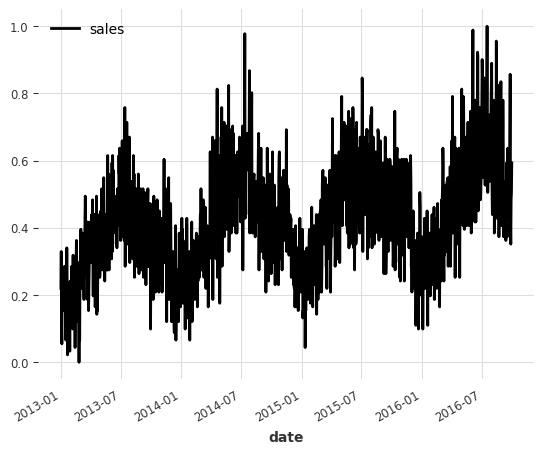

In [49]:
train_scaled.plot()

## N-BEATS

For simplicity, we will keep most of the hyperparameters of the N-BEATS model as default. 
We will jut adjust: 
* input_chunk_length: this is the “lookback window” of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.

* output_chunk_length: this is the “forward window” of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

I'm going to stick with my lag value of 364 as input length. 

In [50]:
RUN_N_BEATS = True #Flag to stop this acidentally running, takes 15 mins
if RUN_N_BEATS:
    model = NBEATSModel(input_chunk_length=364, output_chunk_length=30, random_state=42)
    model.fit([train_scaled], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.9 M 
---------------------------------------------------
8.9 M     Trainable params
3.5 K     Non-trainable params
8.9 M     Total params
70.980    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s, loss=0.00593, train_loss=0.0054] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s, loss=0.00593, train_loss=0.0054]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


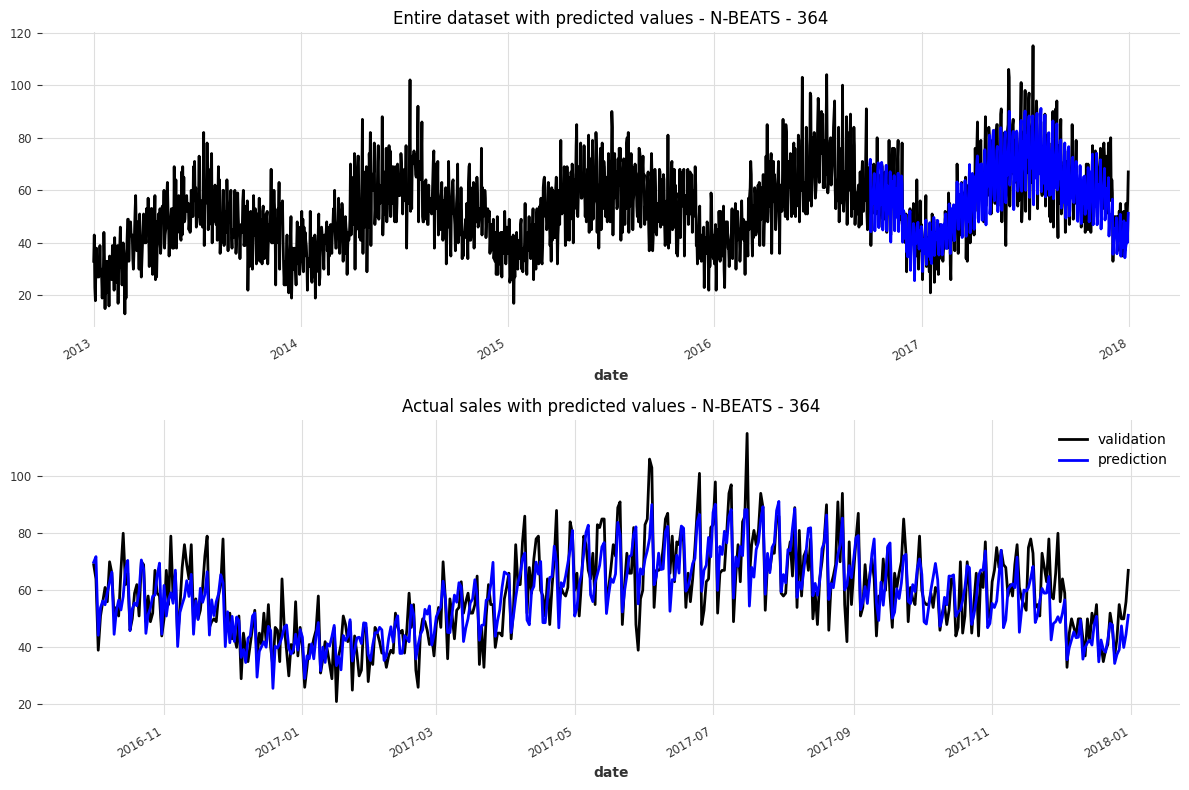

mean squared error for N-BEATS: 12.01


In [51]:
if RUN_N_BEATS:
    pred = model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)

    plot_training_val(entire_series = single_series, 
                    pred = pred, 
                    val = val, 
                    model_name = "N-BEATS - 364")

    print(f"mean squared error for N-BEATS: {smape(single_series, pred):.2f}")
    results_dict['N-BEATS_364'] = smape(single_series, pred)

N Beats has defnitely performed the best so far, with the lowest smape and capturing the data trends well. 

# Temporal Fusion Transformer (TFT)

In [52]:
RUN_TFT = True #Flag to stop this acidentally running, takes 15 mins
if RUN_TFT:
    model = TFTModel(input_chunk_length=364, 
                     output_chunk_length=30, 
                     random_state=42, 
                     add_relative_index = True)

    model.fit([train_scaled], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 1.1 K 
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 528   
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Epoch 49: 100%|██████████| 31/31 [00:11<00:00,  2.67it/s, loss=0.487, train_loss=0.476]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 31/31 [00:11<00:00,  2.67it/s, loss=0.487, train_loss=0.476]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


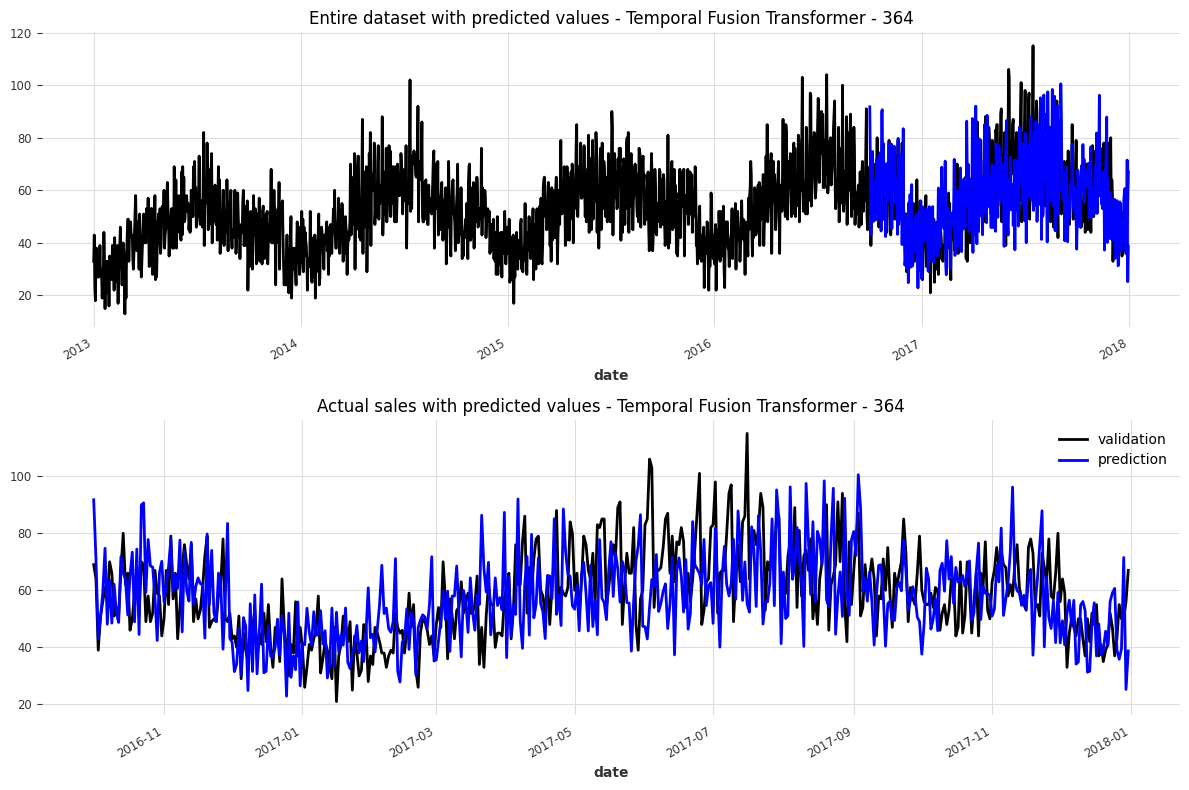

mean squared error for TFT: 23.45


In [53]:
if RUN_TFT:
    pred = model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)

    plot_training_val(entire_series = single_series, 
                    pred = pred, 
                    val = val, 
                    model_name = "Temporal Fusion Transformer - 364")

    print(f"mean squared error for TFT: {smape(single_series, pred):.2f}")
    results_dict['TFT_364'] = smape(single_series, pred)

Not quite as good as the N-BEATS model, especially around the seasonal peak seen in summer. 

# Randomforest

Random forests, especially XGBoost, are typically high performers for typical ML projects. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


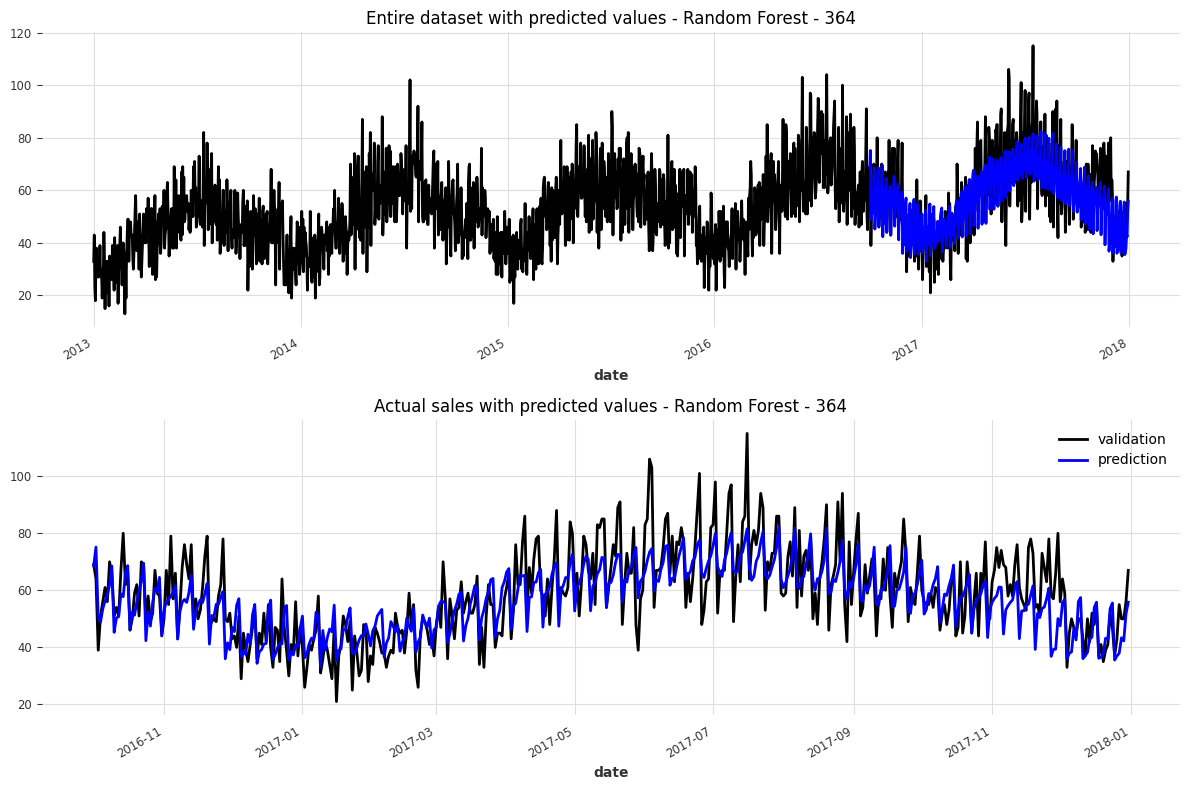

mean squared error for RandomForest: 13.21


In [54]:
model = RandomForest(lags = 364)
model.fit(train_scaled);
pred = model.predict(series=train_scaled, n=len(val))
# scale back:
pred= scaler.inverse_transform(pred)

plot_training_val(entire_series = single_series, 
                pred = pred, 
                val = val, 
                model_name = "Random Forest - 364")

print(f"mean squared error for RandomForest: {smape(single_series, pred):.2f}")
results_dict['random_forest'] = smape(single_series, pred)

Although generating a low smape, the overall fit of the data doesnt see to be as robust as the N-BEATS or TFT models. It certainly doesnt capture the peaks as well as the N-BEATS model. 

# N-BEATS Model Tuning

As the N-BEATS model has performed the best so far, I'm going to tune this only. 

I'm using Optuna for hyperparameter tuning as it is much smarter/quicker than gridsearch. 

In [55]:
def objective(trial):
    input_chunk_length = trial.suggest_int('input_chunk_length',7,365)
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [early_stopper]
    pl_trainer_kwargs = {"callbacks": callbacks}
    N_BEATS_model = NBEATSModel(input_chunk_length=input_chunk_length, 
                                output_chunk_length=30, 
                                random_state=42, 
                                pl_trainer_kwargs=pl_trainer_kwargs)
    N_BEATS_model.fit(train_scaled,val_series = val, epochs=100, verbose=True);
    
    pred = N_BEATS_model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)
    smape_result = smape(single_series, pred)
    print(f"SMAPE: {smape_result}")
    return smape_result

In [56]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [57]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, callbacks=[print_callback])

[I 2022-11-22 21:49:37,177] A new study created in memory with name: no-name-df40d292-f674-4d32-ba9a-14514d8cefff
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.7 M 
---------------------------------------------------
8.6 M     Trainable params
3.3 K     Non-trainable params
8.7 M     Total params
69.219    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.41it/s, loss=0.0378, train_loss=0.027, val_loss=2.5e+3]

Metric val_loss improved. New best score: 2500.696


Epoch 1: 100%|██████████| 35/35 [00:08<00:00,  3.91it/s, loss=0.0194, train_loss=0.0175, val_loss=2.27e+3]

Metric val_loss improved by 233.085 >= min_delta = 0.001. New best score: 2267.612


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.67it/s, loss=0.0144, train_loss=0.0132, val_loss=2.09e+3]

Metric val_loss improved by 176.750 >= min_delta = 0.001. New best score: 2090.862


Epoch 3: 100%|██████████| 35/35 [00:07<00:00,  4.65it/s, loss=0.0127, train_loss=0.014, val_loss=1.79e+3] 

Metric val_loss improved by 297.064 >= min_delta = 0.001. New best score: 1793.797


Epoch 4: 100%|██████████| 35/35 [00:07<00:00,  4.50it/s, loss=0.0119, train_loss=0.0123, val_loss=1.66e+3]

Metric val_loss improved by 134.343 >= min_delta = 0.001. New best score: 1659.455


Epoch 5: 100%|██████████| 35/35 [00:07<00:00,  4.50it/s, loss=0.0109, train_loss=0.0114, val_loss=1.54e+3] 

Metric val_loss improved by 115.720 >= min_delta = 0.001. New best score: 1543.735


Epoch 6: 100%|██████████| 35/35 [00:07<00:00,  4.58it/s, loss=0.0105, train_loss=0.00937, val_loss=1.51e+3]

Metric val_loss improved by 36.023 >= min_delta = 0.001. New best score: 1507.712


Epoch 7: 100%|██████████| 35/35 [00:07<00:00,  4.68it/s, loss=0.0107, train_loss=0.00987, val_loss=1.51e+3]

Metric val_loss improved by 0.843 >= min_delta = 0.001. New best score: 1506.869


Epoch 8: 100%|██████████| 35/35 [00:07<00:00,  4.47it/s, loss=0.00974, train_loss=0.0109, val_loss=1.44e+3] 

Metric val_loss improved by 66.974 >= min_delta = 0.001. New best score: 1439.895


Epoch 10: 100%|██████████| 35/35 [00:07<00:00,  4.68it/s, loss=0.00889, train_loss=0.0095, val_loss=1.36e+3] 

Metric val_loss improved by 78.902 >= min_delta = 0.001. New best score: 1360.992


Epoch 11: 100%|██████████| 35/35 [00:07<00:00,  4.62it/s, loss=0.00867, train_loss=0.00894, val_loss=1.35e+3]

Metric val_loss improved by 8.895 >= min_delta = 0.001. New best score: 1352.097


Epoch 12: 100%|██████████| 35/35 [00:08<00:00,  4.31it/s, loss=0.00946, train_loss=0.0111, val_loss=1.35e+3] 

Metric val_loss improved by 5.256 >= min_delta = 0.001. New best score: 1346.841


Epoch 13: 100%|██████████| 35/35 [00:07<00:00,  4.63it/s, loss=0.00846, train_loss=0.00822, val_loss=1.33e+3]

Metric val_loss improved by 16.281 >= min_delta = 0.001. New best score: 1330.560


Epoch 14: 100%|██████████| 35/35 [00:07<00:00,  4.44it/s, loss=0.00853, train_loss=0.00742, val_loss=1.32e+3]

Metric val_loss improved by 10.112 >= min_delta = 0.001. New best score: 1320.448


Epoch 15: 100%|██████████| 35/35 [00:07<00:00,  4.52it/s, loss=0.00841, train_loss=0.00729, val_loss=1.27e+3]

Metric val_loss improved by 48.391 >= min_delta = 0.001. New best score: 1272.057


Epoch 16: 100%|██████████| 35/35 [00:07<00:00,  4.67it/s, loss=0.00806, train_loss=0.00707, val_loss=1.27e+3]

Metric val_loss improved by 4.577 >= min_delta = 0.001. New best score: 1267.480


Epoch 18: 100%|██████████| 35/35 [00:07<00:00,  4.68it/s, loss=0.00826, train_loss=0.00986, val_loss=1.25e+3]

Metric val_loss improved by 12.539 >= min_delta = 0.001. New best score: 1254.941


Epoch 21: 100%|██████████| 35/35 [00:07<00:00,  4.72it/s, loss=0.00837, train_loss=0.00916, val_loss=1.27e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1254.941. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


[I 2022-11-22 21:52:27,482] Trial 0 finished with value: 13.28373577182349 and parameters: {'input_chunk_length': 336}. Best is trial 0 with value: 13.28373577182349.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 13.28373577182349
Current value: 13.28373577182349, Current params: {'input_chunk_length': 336}
Best value: 13.28373577182349, Best params: {'input_chunk_length': 336}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.7 M 
---------------------------------------------------
6.7 M     Trainable params
1.8 K     Non-trainable params
6.7 M     Total params
53.499    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 51/51 [00:08<00:00,  6.07it/s, loss=0.0265, train_loss=0.0183, val_loss=2.73e+3]

Metric val_loss improved. New best score: 2730.685


Epoch 1: 100%|██████████| 51/51 [00:08<00:00,  6.20it/s, loss=0.0159, train_loss=0.0124, val_loss=2.16e+3]

Metric val_loss improved by 566.960 >= min_delta = 0.001. New best score: 2163.725


Epoch 2: 100%|██████████| 51/51 [00:08<00:00,  6.13it/s, loss=0.0133, train_loss=0.0151, val_loss=2.14e+3]

Metric val_loss improved by 26.698 >= min_delta = 0.001. New best score: 2137.027


Epoch 3: 100%|██████████| 51/51 [00:08<00:00,  6.29it/s, loss=0.0119, train_loss=0.0121, val_loss=2.07e+3]

Metric val_loss improved by 63.123 >= min_delta = 0.001. New best score: 2073.904


Epoch 4: 100%|██████████| 51/51 [00:08<00:00,  6.19it/s, loss=0.0122, train_loss=0.0141, val_loss=2.05e+3] 

Metric val_loss improved by 26.924 >= min_delta = 0.001. New best score: 2046.980


Epoch 7: 100%|██████████| 51/51 [00:08<00:00,  6.20it/s, loss=0.0105, train_loss=0.00906, val_loss=2.07e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2046.980. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


[I 2022-11-22 21:53:34,313] Trial 1 finished with value: 33.22317393854085 and parameters: {'input_chunk_length': 86}. Best is trial 0 with value: 13.28373577182349.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 33.22317393854085
Current value: 33.22317393854085, Current params: {'input_chunk_length': 86}
Best value: 13.28373577182349, Best params: {'input_chunk_length': 336}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.6 M 
---------------------------------------------------
8.6 M     Trainable params
3.3 K     Non-trainable params
8.6 M     Total params
69.031    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s, loss=0.0319, train_loss=0.0226, val_loss=3.02e+3]

Metric val_loss improved. New best score: 3019.321


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.47it/s, loss=0.0173, train_loss=0.0146, val_loss=2.63e+3]

Metric val_loss improved by 386.719 >= min_delta = 0.001. New best score: 2632.603


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.52it/s, loss=0.0139, train_loss=0.015, val_loss=2.28e+3] 

Metric val_loss improved by 355.009 >= min_delta = 0.001. New best score: 2277.593


Epoch 3: 100%|██████████| 35/35 [00:07<00:00,  4.63it/s, loss=0.012, train_loss=0.011, val_loss=2.21e+3]  

Metric val_loss improved by 68.741 >= min_delta = 0.001. New best score: 2208.853


Epoch 4: 100%|██████████| 35/35 [00:07<00:00,  4.60it/s, loss=0.0113, train_loss=0.0093, val_loss=2.07e+3]

Metric val_loss improved by 140.621 >= min_delta = 0.001. New best score: 2068.232


Epoch 5: 100%|██████████| 35/35 [00:07<00:00,  4.59it/s, loss=0.0111, train_loss=0.0105, val_loss=1.99e+3] 

Metric val_loss improved by 77.586 >= min_delta = 0.001. New best score: 1990.646


Epoch 8: 100%|██████████| 35/35 [00:07<00:00,  4.63it/s, loss=0.0096, train_loss=0.00747, val_loss=2.05e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1990.646. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

[I 2022-11-22 21:54:44,870] Trial 2 finished with value: 14.068185519921595 and parameters: {'input_chunk_length': 333}. Best is trial 0 with value: 13.28373577182349.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 14.068185519921595
Current value: 14.068185519921595, Current params: {'input_chunk_length': 333}
Best value: 13.28373577182349, Best params: {'input_chunk_length': 336}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.4 M 
---------------------------------------------------
8.4 M     Trainable params
3.1 K     Non-trainable params
8.4 M     Total params
67.522    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 37/37 [00:09<00:00,  4.04it/s, loss=0.0323, train_loss=0.0206, val_loss=3.43e+3]

Metric val_loss improved. New best score: 3427.138


Epoch 1: 100%|██████████| 37/37 [00:07<00:00,  4.71it/s, loss=0.0207, train_loss=0.0165, val_loss=3.15e+3]

Metric val_loss improved by 277.268 >= min_delta = 0.001. New best score: 3149.869


Epoch 2: 100%|██████████| 37/37 [00:08<00:00,  4.52it/s, loss=0.0153, train_loss=0.0128, val_loss=2.7e+3] 

Metric val_loss improved by 450.015 >= min_delta = 0.001. New best score: 2699.854


Epoch 3: 100%|██████████| 37/37 [00:07<00:00,  4.72it/s, loss=0.0128, train_loss=0.0126, val_loss=2.36e+3]

Metric val_loss improved by 339.317 >= min_delta = 0.001. New best score: 2360.537


Epoch 4: 100%|██████████| 37/37 [00:08<00:00,  4.33it/s, loss=0.0122, train_loss=0.0124, val_loss=2.21e+3]

Metric val_loss improved by 148.644 >= min_delta = 0.001. New best score: 2211.893


Epoch 5: 100%|██████████| 37/37 [00:07<00:00,  4.69it/s, loss=0.0115, train_loss=0.0106, val_loss=2.07e+3] 

Metric val_loss improved by 138.521 >= min_delta = 0.001. New best score: 2073.372


Epoch 6: 100%|██████████| 37/37 [00:07<00:00,  4.73it/s, loss=0.0103, train_loss=0.00768, val_loss=1.97e+3]

Metric val_loss improved by 105.831 >= min_delta = 0.001. New best score: 1967.542


Epoch 9: 100%|██████████| 37/37 [00:07<00:00,  4.72it/s, loss=0.00948, train_loss=0.0091, val_loss=1.89e+3] 

Metric val_loss improved by 75.024 >= min_delta = 0.001. New best score: 1892.518


Epoch 12: 100%|██████████| 37/37 [00:07<00:00,  4.63it/s, loss=0.00911, train_loss=0.0106, val_loss=1.88e+3] 

Metric val_loss improved by 8.667 >= min_delta = 0.001. New best score: 1883.851


Epoch 14: 100%|██████████| 37/37 [00:07<00:00,  4.72it/s, loss=0.00883, train_loss=0.00975, val_loss=1.88e+3]

Metric val_loss improved by 0.507 >= min_delta = 0.001. New best score: 1883.344


Epoch 15: 100%|██████████| 37/37 [00:08<00:00,  4.61it/s, loss=0.00854, train_loss=0.00941, val_loss=1.84e+3]

Metric val_loss improved by 44.308 >= min_delta = 0.001. New best score: 1839.036


Epoch 16: 100%|██████████| 37/37 [00:07<00:00,  4.74it/s, loss=0.00868, train_loss=0.00791, val_loss=1.84e+3]

Metric val_loss improved by 2.133 >= min_delta = 0.001. New best score: 1836.903


Epoch 17: 100%|██████████| 37/37 [00:07<00:00,  4.77it/s, loss=0.00842, train_loss=0.00774, val_loss=1.79e+3]

Metric val_loss improved by 50.304 >= min_delta = 0.001. New best score: 1786.599


Epoch 19: 100%|██████████| 37/37 [00:12<00:00,  2.87it/s, loss=0.00798, train_loss=0.00811, val_loss=1.76e+3]

Metric val_loss improved by 23.214 >= min_delta = 0.001. New best score: 1763.385


Epoch 20: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s, loss=0.00833, train_loss=0.00947, val_loss=1.75e+3]

Metric val_loss improved by 9.663 >= min_delta = 0.001. New best score: 1753.722


Epoch 22: 100%|██████████| 37/37 [00:09<00:00,  4.03it/s, loss=0.00832, train_loss=0.00973, val_loss=1.75e+3]

Metric val_loss improved by 5.253 >= min_delta = 0.001. New best score: 1748.469


Epoch 25: 100%|██████████| 37/37 [00:09<00:00,  4.00it/s, loss=0.00787, train_loss=0.00668, val_loss=1.76e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1748.469. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

[I 2022-11-22 21:58:27,304] Trial 3 finished with value: 13.130930717702615 and parameters: {'input_chunk_length': 309}. Best is trial 3 with value: 13.130930717702615.



SMAPE: 13.130930717702615
Current value: 13.130930717702615, Current params: {'input_chunk_length': 309}
Best value: 13.130930717702615, Best params: {'input_chunk_length': 309}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.8 K     Non-trainable params
6.6 M     Total params
53.059    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 51/51 [00:09<00:00,  5.14it/s, loss=0.026, train_loss=0.0231, val_loss=3.91e+3]

Metric val_loss improved. New best score: 3914.578


Epoch 1: 100%|██████████| 51/51 [00:09<00:00,  5.24it/s, loss=0.0158, train_loss=0.0169, val_loss=3.28e+3]

Metric val_loss improved by 634.884 >= min_delta = 0.001. New best score: 3279.694


Epoch 2: 100%|██████████| 51/51 [00:09<00:00,  5.25it/s, loss=0.0145, train_loss=0.0157, val_loss=3.2e+3] 

Metric val_loss improved by 80.478 >= min_delta = 0.001. New best score: 3199.215


Epoch 3: 100%|██████████| 51/51 [00:09<00:00,  5.27it/s, loss=0.0126, train_loss=0.0123, val_loss=3.11e+3]

Metric val_loss improved by 92.742 >= min_delta = 0.001. New best score: 3106.473


Epoch 5: 100%|██████████| 51/51 [00:10<00:00,  4.85it/s, loss=0.0119, train_loss=0.0115, val_loss=3.07e+3] 

Metric val_loss improved by 35.764 >= min_delta = 0.001. New best score: 3070.709


Epoch 6: 100%|██████████| 51/51 [00:09<00:00,  5.20it/s, loss=0.0107, train_loss=0.00957, val_loss=3.04e+3]

Metric val_loss improved by 29.966 >= min_delta = 0.001. New best score: 3040.742


Epoch 8: 100%|██████████| 51/51 [00:10<00:00,  4.93it/s, loss=0.0104, train_loss=0.00898, val_loss=3.02e+3]

Metric val_loss improved by 25.480 >= min_delta = 0.001. New best score: 3015.262


Epoch 11: 100%|██████████| 51/51 [00:09<00:00,  5.24it/s, loss=0.0111, train_loss=0.0118, val_loss=3.02e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 3015.262. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

[I 2022-11-22 22:00:27,877] Trial 4 finished with value: 26.154572784073054 and parameters: {'input_chunk_length': 79}. Best is trial 3 with value: 13.130930717702615.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 26.154572784073054
Current value: 26.154572784073054, Current params: {'input_chunk_length': 79}
Best value: 13.130930717702615, Best params: {'input_chunk_length': 309}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.1 M 
---------------------------------------------------
7.1 M     Trainable params
2.1 K     Non-trainable params
7.1 M     Total params
57.146    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 47/47 [00:10<00:00,  4.66it/s, loss=0.026, train_loss=0.0206, val_loss=4.14e+3]

Metric val_loss improved. New best score: 4136.954


Epoch 1: 100%|██████████| 47/47 [00:09<00:00,  4.75it/s, loss=0.0164, train_loss=0.0151, val_loss=3.65e+3]

Metric val_loss improved by 487.807 >= min_delta = 0.001. New best score: 3649.147


Epoch 2: 100%|██████████| 47/47 [00:09<00:00,  4.84it/s, loss=0.0134, train_loss=0.0145, val_loss=3.39e+3]

Metric val_loss improved by 259.039 >= min_delta = 0.001. New best score: 3390.108


Epoch 3: 100%|██████████| 47/47 [00:09<00:00,  4.90it/s, loss=0.012, train_loss=0.0115, val_loss=3.35e+3] 

Metric val_loss improved by 38.327 >= min_delta = 0.001. New best score: 3351.781


Epoch 4: 100%|██████████| 47/47 [00:10<00:00,  4.61it/s, loss=0.0126, train_loss=0.0124, val_loss=3.33e+3]

Metric val_loss improved by 22.433 >= min_delta = 0.001. New best score: 3329.347


Epoch 5: 100%|██████████| 47/47 [00:09<00:00,  4.88it/s, loss=0.0114, train_loss=0.00825, val_loss=3.31e+3]

Metric val_loss improved by 19.172 >= min_delta = 0.001. New best score: 3310.176


Epoch 6: 100%|██████████| 47/47 [00:09<00:00,  4.76it/s, loss=0.0105, train_loss=0.0123, val_loss=3.3e+3]  

Metric val_loss improved by 6.314 >= min_delta = 0.001. New best score: 3303.862


Epoch 7: 100%|██████████| 47/47 [00:09<00:00,  4.81it/s, loss=0.0107, train_loss=0.0131, val_loss=3.25e+3]

Metric val_loss improved by 57.835 >= min_delta = 0.001. New best score: 3246.027


Epoch 8: 100%|██████████| 47/47 [00:09<00:00,  4.86it/s, loss=0.00997, train_loss=0.00792, val_loss=3.2e+3] 

Metric val_loss improved by 50.845 >= min_delta = 0.001. New best score: 3195.181


Epoch 11: 100%|██████████| 47/47 [00:09<00:00,  4.86it/s, loss=0.00906, train_loss=0.00889, val_loss=3.29e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 3195.181. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

[I 2022-11-22 22:02:27,323] Trial 5 finished with value: 23.98259110454687 and parameters: {'input_chunk_length': 144}. Best is trial 3 with value: 13.130930717702615.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 23.98259110454687
Current value: 23.98259110454687, Current params: {'input_chunk_length': 144}
Best value: 13.130930717702615, Best params: {'input_chunk_length': 309}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
52.556    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 52/52 [00:10<00:00,  4.92it/s, loss=0.0239, train_loss=0.0202, val_loss=2.51e+3]

Metric val_loss improved. New best score: 2513.062


Epoch 1: 100%|██████████| 52/52 [00:09<00:00,  5.26it/s, loss=0.0154, train_loss=0.014, val_loss=1.89e+3] 

Metric val_loss improved by 622.389 >= min_delta = 0.001. New best score: 1890.673


Epoch 2: 100%|██████████| 52/52 [00:10<00:00,  4.98it/s, loss=0.0123, train_loss=0.0129, val_loss=1.85e+3]

Metric val_loss improved by 39.186 >= min_delta = 0.001. New best score: 1851.487


Epoch 3: 100%|██████████| 52/52 [00:09<00:00,  5.21it/s, loss=0.0121, train_loss=0.0128, val_loss=1.82e+3]

Metric val_loss improved by 32.534 >= min_delta = 0.001. New best score: 1818.953


Epoch 5: 100%|██████████| 52/52 [00:09<00:00,  5.24it/s, loss=0.0111, train_loss=0.0103, val_loss=1.81e+3] 

Metric val_loss improved by 12.174 >= min_delta = 0.001. New best score: 1806.779


Epoch 6: 100%|██████████| 52/52 [00:10<00:00,  5.12it/s, loss=0.0116, train_loss=0.0141, val_loss=1.8e+3]  

Metric val_loss improved by 4.896 >= min_delta = 0.001. New best score: 1801.882


Epoch 8: 100%|██████████| 52/52 [00:09<00:00,  5.31it/s, loss=0.0105, train_loss=0.00985, val_loss=1.76e+3]

Metric val_loss improved by 43.552 >= min_delta = 0.001. New best score: 1758.330


Epoch 11: 100%|██████████| 52/52 [00:10<00:00,  4.79it/s, loss=0.0104, train_loss=0.00935, val_loss=1.78e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1758.330. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

[I 2022-11-22 22:04:30,242] Trial 6 finished with value: 25.771928781327986 and parameters: {'input_chunk_length': 71}. Best is trial 3 with value: 13.130930717702615.



SMAPE: 25.771928781327986
Current value: 25.771928781327986, Current params: {'input_chunk_length': 71}
Best value: 13.130930717702615, Best params: {'input_chunk_length': 309}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.0 M 
---------------------------------------------------
8.0 M     Trainable params
2.8 K     Non-trainable params
8.0 M     Total params
64.252    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 40/40 [00:12<00:00,  3.32it/s, loss=0.0291, train_loss=0.0226, val_loss=4.25e+3]

Metric val_loss improved. New best score: 4249.092


Epoch 1: 100%|██████████| 40/40 [00:09<00:00,  4.00it/s, loss=0.0182, train_loss=0.0163, val_loss=3.79e+3]

Metric val_loss improved by 461.259 >= min_delta = 0.001. New best score: 3787.833


Epoch 2: 100%|██████████| 40/40 [00:09<00:00,  4.25it/s, loss=0.014, train_loss=0.0147, val_loss=3.05e+3] 

Metric val_loss improved by 739.593 >= min_delta = 0.001. New best score: 3048.240


Epoch 3: 100%|██████████| 40/40 [00:09<00:00,  4.27it/s, loss=0.0125, train_loss=0.0116, val_loss=2.74e+3]

Metric val_loss improved by 310.303 >= min_delta = 0.001. New best score: 2737.937


Epoch 4: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s, loss=0.0115, train_loss=0.011, val_loss=2.65e+3] 

Metric val_loss improved by 83.832 >= min_delta = 0.001. New best score: 2654.105


Epoch 5: 100%|██████████| 40/40 [00:09<00:00,  4.06it/s, loss=0.0107, train_loss=0.0109, val_loss=2.46e+3] 

Metric val_loss improved by 194.883 >= min_delta = 0.001. New best score: 2459.222


Epoch 6: 100%|██████████| 40/40 [00:09<00:00,  4.28it/s, loss=0.0103, train_loss=0.0102, val_loss=2.43e+3] 

Metric val_loss improved by 31.340 >= min_delta = 0.001. New best score: 2427.882


Epoch 7: 100%|██████████| 40/40 [00:09<00:00,  4.05it/s, loss=0.00945, train_loss=0.00957, val_loss=2.23e+3]

Metric val_loss improved by 198.887 >= min_delta = 0.001. New best score: 2228.995


Epoch 8: 100%|██████████| 40/40 [00:09<00:00,  4.25it/s, loss=0.00889, train_loss=0.00829, val_loss=2.14e+3]

Metric val_loss improved by 89.088 >= min_delta = 0.001. New best score: 2139.907


Epoch 9: 100%|██████████| 40/40 [00:09<00:00,  4.08it/s, loss=0.00929, train_loss=0.00794, val_loss=2.12e+3]

Metric val_loss improved by 23.481 >= min_delta = 0.001. New best score: 2116.426


Epoch 11: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s, loss=0.00884, train_loss=0.00848, val_loss=2.02e+3]

Metric val_loss improved by 93.796 >= min_delta = 0.001. New best score: 2022.630


Epoch 12: 100%|██████████| 40/40 [00:09<00:00,  4.32it/s, loss=0.00877, train_loss=0.0079, val_loss=2.02e+3] 

Metric val_loss improved by 3.243 >= min_delta = 0.001. New best score: 2019.387


Epoch 13: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, loss=0.00824, train_loss=0.00818, val_loss=1.98e+3]

Metric val_loss improved by 41.606 >= min_delta = 0.001. New best score: 1977.781


Epoch 16: 100%|██████████| 40/40 [00:09<00:00,  4.27it/s, loss=0.00802, train_loss=0.00824, val_loss=1.93e+3]

Metric val_loss improved by 43.453 >= min_delta = 0.001. New best score: 1934.327


Epoch 17: 100%|██████████| 40/40 [00:09<00:00,  4.29it/s, loss=0.0081, train_loss=0.00853, val_loss=1.86e+3] 

Metric val_loss improved by 72.072 >= min_delta = 0.001. New best score: 1862.255


Epoch 18: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, loss=0.00787, train_loss=0.00797, val_loss=1.77e+3]

Metric val_loss improved by 89.868 >= min_delta = 0.001. New best score: 1772.388


Epoch 20: 100%|██████████| 40/40 [00:09<00:00,  4.13it/s, loss=0.00799, train_loss=0.00869, val_loss=1.76e+3]

Metric val_loss improved by 10.837 >= min_delta = 0.001. New best score: 1761.551


Epoch 21: 100%|██████████| 40/40 [00:09<00:00,  4.28it/s, loss=0.00777, train_loss=0.00641, val_loss=1.7e+3] 

Metric val_loss improved by 61.721 >= min_delta = 0.001. New best score: 1699.830


Epoch 22: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s, loss=0.00737, train_loss=0.00744, val_loss=1.66e+3]

Metric val_loss improved by 38.449 >= min_delta = 0.001. New best score: 1661.381


Epoch 23: 100%|██████████| 40/40 [00:09<00:00,  4.29it/s, loss=0.00745, train_loss=0.00713, val_loss=1.66e+3]

Metric val_loss improved by 4.159 >= min_delta = 0.001. New best score: 1657.222


Epoch 24: 100%|██████████| 40/40 [00:09<00:00,  4.29it/s, loss=0.00738, train_loss=0.00792, val_loss=1.62e+3]

Metric val_loss improved by 41.434 >= min_delta = 0.001. New best score: 1615.788


Epoch 25: 100%|██████████| 40/40 [00:09<00:00,  4.06it/s, loss=0.00723, train_loss=0.00702, val_loss=1.56e+3]

Metric val_loss improved by 56.093 >= min_delta = 0.001. New best score: 1559.695


Epoch 26: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s, loss=0.00719, train_loss=0.00744, val_loss=1.54e+3]

Metric val_loss improved by 15.983 >= min_delta = 0.001. New best score: 1543.713


Epoch 27: 100%|██████████| 40/40 [00:09<00:00,  4.18it/s, loss=0.00737, train_loss=0.00725, val_loss=1.53e+3]

Metric val_loss improved by 13.672 >= min_delta = 0.001. New best score: 1530.041


Epoch 29: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, loss=0.00695, train_loss=0.00657, val_loss=1.52e+3]

Metric val_loss improved by 14.272 >= min_delta = 0.001. New best score: 1515.769


Epoch 30: 100%|██████████| 40/40 [00:10<00:00,  3.92it/s, loss=0.00692, train_loss=0.00685, val_loss=1.42e+3]

Metric val_loss improved by 93.109 >= min_delta = 0.001. New best score: 1422.660


Epoch 33: 100%|██████████| 40/40 [00:09<00:00,  4.18it/s, loss=0.00662, train_loss=0.00582, val_loss=1.33e+3]

Metric val_loss improved by 90.856 >= min_delta = 0.001. New best score: 1331.804


Epoch 36: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s, loss=0.00657, train_loss=0.00615, val_loss=1.43e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1331.804. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

[I 2022-11-22 22:10:28,786] Trial 7 finished with value: 13.123579322785881 and parameters: {'input_chunk_length': 257}. Best is trial 7 with value: 13.123579322785881.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 13.123579322785881
Current value: 13.123579322785881, Current params: {'input_chunk_length': 257}
Best value: 13.123579322785881, Best params: {'input_chunk_length': 257}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.4 M 
---------------------------------------------------
7.4 M     Trainable params
2.3 K     Non-trainable params
7.4 M     Total params
59.159    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 45/45 [00:09<00:00,  4.71it/s, loss=0.0281, train_loss=0.0215, val_loss=3.29e+3]

Metric val_loss improved. New best score: 3294.515


Epoch 1: 100%|██████████| 45/45 [00:09<00:00,  4.56it/s, loss=0.0174, train_loss=0.0149, val_loss=2.96e+3]

Metric val_loss improved by 332.484 >= min_delta = 0.001. New best score: 2962.031


Epoch 2: 100%|██████████| 45/45 [00:09<00:00,  4.56it/s, loss=0.0145, train_loss=0.012, val_loss=2.71e+3] 

Metric val_loss improved by 252.979 >= min_delta = 0.001. New best score: 2709.052


Epoch 3: 100%|██████████| 45/45 [00:09<00:00,  4.65it/s, loss=0.0128, train_loss=0.0112, val_loss=2.52e+3]

Metric val_loss improved by 193.278 >= min_delta = 0.001. New best score: 2515.774


Epoch 4: 100%|██████████| 45/45 [00:09<00:00,  4.67it/s, loss=0.0123, train_loss=0.0118, val_loss=2.38e+3]

Metric val_loss improved by 138.851 >= min_delta = 0.001. New best score: 2376.923


Epoch 5: 100%|██████████| 45/45 [00:10<00:00,  4.44it/s, loss=0.0117, train_loss=0.0107, val_loss=2.31e+3]

Metric val_loss improved by 62.974 >= min_delta = 0.001. New best score: 2313.949


Epoch 6: 100%|██████████| 45/45 [00:09<00:00,  4.62it/s, loss=0.0111, train_loss=0.0108, val_loss=2.24e+3] 

Metric val_loss improved by 75.933 >= min_delta = 0.001. New best score: 2238.016


Epoch 7: 100%|██████████| 45/45 [00:10<00:00,  4.48it/s, loss=0.0105, train_loss=0.0103, val_loss=2.18e+3] 

Metric val_loss improved by 56.169 >= min_delta = 0.001. New best score: 2181.847


Epoch 8: 100%|██████████| 45/45 [00:09<00:00,  4.74it/s, loss=0.0101, train_loss=0.00954, val_loss=2.1e+3] 

Metric val_loss improved by 86.253 >= min_delta = 0.001. New best score: 2095.595


Epoch 11: 100%|██████████| 45/45 [00:09<00:00,  4.72it/s, loss=0.00985, train_loss=0.00874, val_loss=2.17e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2095.595. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

[I 2022-11-22 22:12:26,873] Trial 8 finished with value: 19.19438388854393 and parameters: {'input_chunk_length': 176}. Best is trial 7 with value: 13.123579322785881.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 19.19438388854393
Current value: 19.19438388854393, Current params: {'input_chunk_length': 176}
Best value: 13.123579322785881, Best params: {'input_chunk_length': 257}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.4 M 
---------------------------------------------------
8.4 M     Trainable params
3.1 K     Non-trainable params
8.4 M     Total params
67.584    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s, loss=0.0278, train_loss=0.0242, val_loss=3.34e+3]

Metric val_loss improved. New best score: 3336.675


Epoch 1: 100%|██████████| 37/37 [00:09<00:00,  4.08it/s, loss=0.0153, train_loss=0.0162, val_loss=2.63e+3]

Metric val_loss improved by 702.512 >= min_delta = 0.001. New best score: 2634.162


Epoch 2: 100%|██████████| 37/37 [00:09<00:00,  4.02it/s, loss=0.0133, train_loss=0.0105, val_loss=2.04e+3]

Metric val_loss improved by 595.698 >= min_delta = 0.001. New best score: 2038.464


Epoch 3: 100%|██████████| 37/37 [00:09<00:00,  4.09it/s, loss=0.0113, train_loss=0.0093, val_loss=1.9e+3] 

Metric val_loss improved by 141.197 >= min_delta = 0.001. New best score: 1897.267


Epoch 4: 100%|██████████| 37/37 [00:09<00:00,  4.07it/s, loss=0.0107, train_loss=0.00951, val_loss=1.88e+3]

Metric val_loss improved by 20.915 >= min_delta = 0.001. New best score: 1876.352


Epoch 5: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s, loss=0.00988, train_loss=0.00784, val_loss=1.75e+3]

Metric val_loss improved by 129.390 >= min_delta = 0.001. New best score: 1746.962


Epoch 7: 100%|██████████| 37/37 [00:08<00:00,  4.13it/s, loss=0.00961, train_loss=0.0108, val_loss=1.72e+3] 

Metric val_loss improved by 30.244 >= min_delta = 0.001. New best score: 1716.718


Epoch 8: 100%|██████████| 37/37 [00:09<00:00,  4.03it/s, loss=0.00922, train_loss=0.00797, val_loss=1.62e+3]

Metric val_loss improved by 100.952 >= min_delta = 0.001. New best score: 1615.766


Epoch 9: 100%|██████████| 37/37 [00:09<00:00,  4.07it/s, loss=0.0087, train_loss=0.0117, val_loss=1.54e+3]  

Metric val_loss improved by 75.929 >= min_delta = 0.001. New best score: 1539.837


Epoch 11: 100%|██████████| 37/37 [00:08<00:00,  4.12it/s, loss=0.00843, train_loss=0.00628, val_loss=1.51e+3]

Metric val_loss improved by 32.909 >= min_delta = 0.001. New best score: 1506.929


Epoch 13: 100%|██████████| 37/37 [00:09<00:00,  3.96it/s, loss=0.00837, train_loss=0.00778, val_loss=1.46e+3]

Metric val_loss improved by 46.528 >= min_delta = 0.001. New best score: 1460.401


Epoch 14: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s, loss=0.0085, train_loss=0.00978, val_loss=1.44e+3] 

Metric val_loss improved by 16.703 >= min_delta = 0.001. New best score: 1443.697


Epoch 16: 100%|██████████| 37/37 [00:09<00:00,  4.11it/s, loss=0.00796, train_loss=0.00754, val_loss=1.43e+3]

Metric val_loss improved by 11.369 >= min_delta = 0.001. New best score: 1432.328


Epoch 17: 100%|██████████| 37/37 [00:09<00:00,  3.97it/s, loss=0.00789, train_loss=0.00759, val_loss=1.38e+3]

Metric val_loss improved by 50.596 >= min_delta = 0.001. New best score: 1381.732


Epoch 18: 100%|██████████| 37/37 [00:09<00:00,  4.01it/s, loss=0.00764, train_loss=0.00634, val_loss=1.38e+3]

Metric val_loss improved by 4.708 >= min_delta = 0.001. New best score: 1377.024


Epoch 21: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s, loss=0.00781, train_loss=0.00855, val_loss=1.39e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1377.024. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

[I 2022-11-22 22:15:52,721] Trial 9 finished with value: 12.587307095828901 and parameters: {'input_chunk_length': 310}. Best is trial 9 with value: 12.587307095828901.



SMAPE: 12.587307095828901
Current value: 12.587307095828901, Current params: {'input_chunk_length': 310}
Best value: 12.587307095828901, Best params: {'input_chunk_length': 310}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.9 M 
---------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
63.434    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 41/41 [00:09<00:00,  4.28it/s, loss=0.0314, train_loss=0.0242, val_loss=4.95e+3]

Metric val_loss improved. New best score: 4950.737


Epoch 1: 100%|██████████| 41/41 [00:09<00:00,  4.28it/s, loss=0.0181, train_loss=0.0156, val_loss=4.52e+3]

Metric val_loss improved by 429.576 >= min_delta = 0.001. New best score: 4521.162


Epoch 2: 100%|██████████| 41/41 [00:09<00:00,  4.17it/s, loss=0.0144, train_loss=0.013, val_loss=3.91e+3] 

Metric val_loss improved by 609.632 >= min_delta = 0.001. New best score: 3911.529


Epoch 3: 100%|██████████| 41/41 [00:09<00:00,  4.29it/s, loss=0.0129, train_loss=0.0148, val_loss=3.52e+3]

Metric val_loss improved by 387.827 >= min_delta = 0.001. New best score: 3523.702


Epoch 4: 100%|██████████| 41/41 [00:09<00:00,  4.31it/s, loss=0.012, train_loss=0.0123, val_loss=3.44e+3] 

Metric val_loss improved by 81.180 >= min_delta = 0.001. New best score: 3442.522


Epoch 5: 100%|██████████| 41/41 [00:09<00:00,  4.18it/s, loss=0.011, train_loss=0.0108, val_loss=3.33e+3] 

Metric val_loss improved by 115.674 >= min_delta = 0.001. New best score: 3326.848


Epoch 6: 100%|██████████| 41/41 [00:09<00:00,  4.24it/s, loss=0.0103, train_loss=0.00995, val_loss=3.28e+3]

Metric val_loss improved by 48.010 >= min_delta = 0.001. New best score: 3278.838


Epoch 8: 100%|██████████| 41/41 [00:09<00:00,  4.32it/s, loss=0.0102, train_loss=0.0127, val_loss=3.28e+3]  

Metric val_loss improved by 3.454 >= min_delta = 0.001. New best score: 3275.384


Epoch 11: 100%|██████████| 41/41 [00:09<00:00,  4.30it/s, loss=0.00891, train_loss=0.0112, val_loss=3.6e+3]  

Monitored metric val_loss did not improve in the last 3 records. Best score: 3275.384. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

[I 2022-11-22 22:17:49,877] Trial 10 finished with value: 18.346572723423858 and parameters: {'input_chunk_length': 244}. Best is trial 9 with value: 12.587307095828901.



SMAPE: 18.346572723423858
Current value: 18.346572723423858, Current params: {'input_chunk_length': 244}
Best value: 12.587307095828901, Best params: {'input_chunk_length': 310}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.0 M 
---------------------------------------------------
8.0 M     Trainable params
2.8 K     Non-trainable params
8.0 M     Total params
64.189    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 40/40 [00:09<00:00,  4.12it/s, loss=0.0288, train_loss=0.0235, val_loss=4.69e+3]

Metric val_loss improved. New best score: 4690.762


Epoch 1: 100%|██████████| 40/40 [00:09<00:00,  4.18it/s, loss=0.0167, train_loss=0.0144, val_loss=4.46e+3]

Metric val_loss improved by 226.154 >= min_delta = 0.001. New best score: 4464.607


Epoch 2: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, loss=0.0137, train_loss=0.0126, val_loss=3.79e+3]

Metric val_loss improved by 676.162 >= min_delta = 0.001. New best score: 3788.446


Epoch 3: 100%|██████████| 40/40 [00:09<00:00,  4.25it/s, loss=0.012, train_loss=0.0118, val_loss=3.35e+3] 

Metric val_loss improved by 439.974 >= min_delta = 0.001. New best score: 3348.471


Epoch 4: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s, loss=0.0114, train_loss=0.0114, val_loss=3.25e+3]

Metric val_loss improved by 101.783 >= min_delta = 0.001. New best score: 3246.689


Epoch 5: 100%|██████████| 40/40 [00:09<00:00,  4.01it/s, loss=0.0113, train_loss=0.0117, val_loss=3.23e+3] 

Metric val_loss improved by 17.623 >= min_delta = 0.001. New best score: 3229.066


Epoch 6: 100%|██████████| 40/40 [00:09<00:00,  4.28it/s, loss=0.00961, train_loss=0.00967, val_loss=3.15e+3]

Metric val_loss improved by 79.774 >= min_delta = 0.001. New best score: 3149.292


Epoch 7: 100%|██████████| 40/40 [00:09<00:00,  4.22it/s, loss=0.00946, train_loss=0.00977, val_loss=3.09e+3]

Metric val_loss improved by 58.404 >= min_delta = 0.001. New best score: 3090.888


Epoch 10: 100%|██████████| 40/40 [00:09<00:00,  4.10it/s, loss=0.00872, train_loss=0.00849, val_loss=3.15e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 3090.888. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

[I 2022-11-22 22:19:36,844] Trial 11 finished with value: 13.399602789234141 and parameters: {'input_chunk_length': 256}. Best is trial 9 with value: 12.587307095828901.



SMAPE: 13.399602789234141
Current value: 13.399602789234141, Current params: {'input_chunk_length': 256}
Best value: 12.587307095828901, Best params: {'input_chunk_length': 310}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.0 M 
---------------------------------------------------
8.0 M     Trainable params
2.8 K     Non-trainable params
8.0 M     Total params
64.126    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 40/40 [00:10<00:00,  3.96it/s, loss=0.0351, train_loss=0.026, val_loss=4.53e+3]

Metric val_loss improved. New best score: 4527.529


Epoch 1: 100%|██████████| 40/40 [00:09<00:00,  4.20it/s, loss=0.0199, train_loss=0.017, val_loss=4.35e+3] 

Metric val_loss improved by 180.850 >= min_delta = 0.001. New best score: 4346.679


Epoch 2: 100%|██████████| 40/40 [00:09<00:00,  4.33it/s, loss=0.0151, train_loss=0.0139, val_loss=3.93e+3]

Metric val_loss improved by 416.825 >= min_delta = 0.001. New best score: 3929.855


Epoch 3: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s, loss=0.0129, train_loss=0.0133, val_loss=3.52e+3]

Metric val_loss improved by 412.196 >= min_delta = 0.001. New best score: 3517.659


Epoch 4: 100%|██████████| 40/40 [00:09<00:00,  4.11it/s, loss=0.0118, train_loss=0.0112, val_loss=3.43e+3]

Metric val_loss improved by 86.810 >= min_delta = 0.001. New best score: 3430.849


Epoch 5: 100%|██████████| 40/40 [00:09<00:00,  4.25it/s, loss=0.0109, train_loss=0.0112, val_loss=3.37e+3] 

Metric val_loss improved by 58.831 >= min_delta = 0.001. New best score: 3372.017


Epoch 6: 100%|██████████| 40/40 [00:09<00:00,  4.16it/s, loss=0.011, train_loss=0.0102, val_loss=3.25e+3]  

Metric val_loss improved by 119.173 >= min_delta = 0.001. New best score: 3252.844


Epoch 9: 100%|██████████| 40/40 [00:09<00:00,  4.11it/s, loss=0.00936, train_loss=0.00837, val_loss=3.18e+3]

Metric val_loss improved by 72.416 >= min_delta = 0.001. New best score: 3180.428


Epoch 11: 100%|██████████| 40/40 [00:09<00:00,  4.28it/s, loss=0.00886, train_loss=0.00914, val_loss=3.17e+3]

Metric val_loss improved by 12.446 >= min_delta = 0.001. New best score: 3167.982


Epoch 14: 100%|██████████| 40/40 [00:09<00:00,  4.30it/s, loss=0.00859, train_loss=0.00856, val_loss=3.23e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 3167.982. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

[I 2022-11-22 22:22:01,400] Trial 12 finished with value: 15.111453401269815 and parameters: {'input_chunk_length': 255}. Best is trial 9 with value: 12.587307095828901.



SMAPE: 15.111453401269815
Current value: 15.111453401269815, Current params: {'input_chunk_length': 255}
Best value: 12.587307095828901, Best params: {'input_chunk_length': 310}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.3 M 
---------------------------------------------------
8.3 M     Trainable params
3.0 K     Non-trainable params
8.3 M     Total params
66.264    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 38/38 [00:09<00:00,  4.02it/s, loss=0.0327, train_loss=0.0253, val_loss=3.29e+3]

Metric val_loss improved. New best score: 3287.635


Epoch 1: 100%|██████████| 38/38 [00:09<00:00,  4.03it/s, loss=0.0201, train_loss=0.0179, val_loss=3.16e+3]

Metric val_loss improved by 131.860 >= min_delta = 0.001. New best score: 3155.775


Epoch 2: 100%|██████████| 38/38 [00:09<00:00,  4.06it/s, loss=0.015, train_loss=0.0162, val_loss=2.79e+3] 

Metric val_loss improved by 367.429 >= min_delta = 0.001. New best score: 2788.347


Epoch 3: 100%|██████████| 38/38 [00:09<00:00,  3.95it/s, loss=0.0131, train_loss=0.0126, val_loss=2.35e+3]

Metric val_loss improved by 439.194 >= min_delta = 0.001. New best score: 2349.153


Epoch 4: 100%|██████████| 38/38 [00:09<00:00,  3.96it/s, loss=0.0118, train_loss=0.0126, val_loss=2.12e+3]

Metric val_loss improved by 233.558 >= min_delta = 0.001. New best score: 2115.595


Epoch 5: 100%|██████████| 38/38 [00:09<00:00,  4.08it/s, loss=0.011, train_loss=0.0131, val_loss=2.03e+3]  

Metric val_loss improved by 83.908 >= min_delta = 0.001. New best score: 2031.687


Epoch 6: 100%|██████████| 38/38 [00:09<00:00,  3.99it/s, loss=0.00995, train_loss=0.00902, val_loss=1.99e+3]

Metric val_loss improved by 37.391 >= min_delta = 0.001. New best score: 1994.296


Epoch 8: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s, loss=0.00956, train_loss=0.00934, val_loss=1.97e+3]

Metric val_loss improved by 19.892 >= min_delta = 0.001. New best score: 1974.403


Epoch 10: 100%|██████████| 38/38 [00:09<00:00,  3.99it/s, loss=0.0092, train_loss=0.00988, val_loss=1.95e+3] 

Metric val_loss improved by 23.781 >= min_delta = 0.001. New best score: 1950.622


Epoch 13: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s, loss=0.00861, train_loss=0.00951, val_loss=2.01e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1950.622. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

[I 2022-11-22 22:24:19,331] Trial 13 finished with value: 11.97993078204712 and parameters: {'input_chunk_length': 289}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 11.97993078204712
Current value: 11.97993078204712, Current params: {'input_chunk_length': 289}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.9 M 
---------------------------------------------------
8.9 M     Trainable params
3.5 K     Non-trainable params
8.9 M     Total params
70.917    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, loss=0.0312, train_loss=0.020, val_loss=3.07e+3]

Metric val_loss improved. New best score: 3072.765


Epoch 1: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s, loss=0.0168, train_loss=0.0154, val_loss=2.63e+3]

Metric val_loss improved by 441.147 >= min_delta = 0.001. New best score: 2631.618


Epoch 2: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s, loss=0.0138, train_loss=0.0116, val_loss=2.41e+3]

Metric val_loss improved by 223.287 >= min_delta = 0.001. New best score: 2408.331


Epoch 3: 100%|██████████| 34/34 [00:09<00:00,  3.68it/s, loss=0.0123, train_loss=0.0116, val_loss=2.25e+3]

Metric val_loss improved by 161.204 >= min_delta = 0.001. New best score: 2247.127


Epoch 4: 100%|██████████| 34/34 [00:09<00:00,  3.56it/s, loss=0.0112, train_loss=0.00981, val_loss=2.2e+3] 

Metric val_loss improved by 49.874 >= min_delta = 0.001. New best score: 2197.253


Epoch 5: 100%|██████████| 34/34 [00:09<00:00,  3.63it/s, loss=0.0102, train_loss=0.00891, val_loss=2.08e+3]

Metric val_loss improved by 114.634 >= min_delta = 0.001. New best score: 2082.620


Epoch 6: 100%|██████████| 34/34 [00:09<00:00,  3.60it/s, loss=0.00967, train_loss=0.0111, val_loss=2.05e+3] 

Metric val_loss improved by 34.296 >= min_delta = 0.001. New best score: 2048.323


Epoch 7: 100%|██████████| 34/34 [00:09<00:00,  3.70it/s, loss=0.00992, train_loss=0.0102, val_loss=2.04e+3] 

Metric val_loss improved by 9.879 >= min_delta = 0.001. New best score: 2038.444


Epoch 9: 100%|██████████| 34/34 [00:09<00:00,  3.47it/s, loss=0.00912, train_loss=0.00851, val_loss=1.97e+3]

Metric val_loss improved by 70.245 >= min_delta = 0.001. New best score: 1968.199


Epoch 10: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s, loss=0.00878, train_loss=0.0082, val_loss=1.96e+3] 

Metric val_loss improved by 9.870 >= min_delta = 0.001. New best score: 1958.330


Epoch 11: 100%|██████████| 34/34 [00:09<00:00,  3.64it/s, loss=0.00873, train_loss=0.00953, val_loss=1.93e+3]

Metric val_loss improved by 32.196 >= min_delta = 0.001. New best score: 1926.134


Epoch 12: 100%|██████████| 34/34 [00:09<00:00,  3.66it/s, loss=0.00876, train_loss=0.00863, val_loss=1.92e+3]

Metric val_loss improved by 4.704 >= min_delta = 0.001. New best score: 1921.430


Epoch 13: 100%|██████████| 34/34 [00:09<00:00,  3.53it/s, loss=0.00859, train_loss=0.0098, val_loss=1.86e+3] 

Metric val_loss improved by 64.050 >= min_delta = 0.001. New best score: 1857.379


Epoch 14: 100%|██████████| 34/34 [00:09<00:00,  3.64it/s, loss=0.00862, train_loss=0.00848, val_loss=1.85e+3]

Metric val_loss improved by 5.659 >= min_delta = 0.001. New best score: 1851.721


Epoch 15: 100%|██████████| 34/34 [00:09<00:00,  3.59it/s, loss=0.00845, train_loss=0.00896, val_loss=1.83e+3]

Metric val_loss improved by 23.578 >= min_delta = 0.001. New best score: 1828.143


Epoch 18: 100%|██████████| 34/34 [00:09<00:00,  3.71it/s, loss=0.00785, train_loss=0.00731, val_loss=1.81e+3]

Metric val_loss improved by 21.772 >= min_delta = 0.001. New best score: 1806.370


Epoch 21: 100%|██████████| 34/34 [00:09<00:00,  3.71it/s, loss=0.00801, train_loss=0.00774, val_loss=1.8e+3] 

Metric val_loss improved by 5.319 >= min_delta = 0.001. New best score: 1801.051


Epoch 23: 100%|██████████| 34/34 [00:09<00:00,  3.69it/s, loss=0.00776, train_loss=0.00656, val_loss=1.75e+3]

Metric val_loss improved by 46.990 >= min_delta = 0.001. New best score: 1754.061


Epoch 25: 100%|██████████| 34/34 [00:09<00:00,  3.69it/s, loss=0.00762, train_loss=0.00799, val_loss=1.75e+3]

Metric val_loss improved by 5.202 >= min_delta = 0.001. New best score: 1748.860


Epoch 28: 100%|██████████| 34/34 [00:09<00:00,  3.72it/s, loss=0.00736, train_loss=0.00757, val_loss=1.75e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1748.860. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

[I 2022-11-22 22:28:53,540] Trial 14 finished with value: 13.25309661484511 and parameters: {'input_chunk_length': 363}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 13.25309661484511
Current value: 13.25309661484511, Current params: {'input_chunk_length': 363}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.4 M 
---------------------------------------------------
8.4 M     Trainable params
3.1 K     Non-trainable params
8.4 M     Total params
66.830    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s, loss=0.0314, train_loss=0.0294, val_loss=3.17e+3]

Metric val_loss improved. New best score: 3170.552


Epoch 1: 100%|██████████| 38/38 [00:09<00:00,  4.02it/s, loss=0.0176, train_loss=0.0166, val_loss=2.93e+3]

Metric val_loss improved by 236.904 >= min_delta = 0.001. New best score: 2933.648


Epoch 2: 100%|██████████| 38/38 [00:09<00:00,  3.98it/s, loss=0.0134, train_loss=0.0135, val_loss=2.44e+3]

Metric val_loss improved by 489.374 >= min_delta = 0.001. New best score: 2444.274


Epoch 3: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s, loss=0.0124, train_loss=0.0113, val_loss=2.24e+3]

Metric val_loss improved by 207.224 >= min_delta = 0.001. New best score: 2237.050


Epoch 4: 100%|██████████| 38/38 [00:09<00:00,  4.01it/s, loss=0.0113, train_loss=0.011, val_loss=2.19e+3]  

Metric val_loss improved by 49.103 >= min_delta = 0.001. New best score: 2187.947


Epoch 5: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s, loss=0.0105, train_loss=0.00973, val_loss=2.07e+3]

Metric val_loss improved by 115.977 >= min_delta = 0.001. New best score: 2071.970


Epoch 6: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s, loss=0.0101, train_loss=0.0101, val_loss=2e+3]     

Metric val_loss improved by 70.774 >= min_delta = 0.001. New best score: 2001.196


Epoch 7: 100%|██████████| 38/38 [00:09<00:00,  4.01it/s, loss=0.00925, train_loss=0.00856, val_loss=1.96e+3]

Metric val_loss improved by 36.696 >= min_delta = 0.001. New best score: 1964.500


Epoch 8: 100%|██████████| 38/38 [00:09<00:00,  3.96it/s, loss=0.0091, train_loss=0.0102, val_loss=1.93e+3]  

Metric val_loss improved by 39.073 >= min_delta = 0.001. New best score: 1925.428


Epoch 9: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s, loss=0.00931, train_loss=0.00968, val_loss=1.9e+3] 

Metric val_loss improved by 28.545 >= min_delta = 0.001. New best score: 1896.882


Epoch 12: 100%|██████████| 38/38 [00:09<00:00,  3.99it/s, loss=0.00862, train_loss=0.00959, val_loss=1.86e+3]

Metric val_loss improved by 41.788 >= min_delta = 0.001. New best score: 1855.094


Epoch 15: 100%|██████████| 38/38 [00:09<00:00,  3.99it/s, loss=0.00804, train_loss=0.00794, val_loss=1.8e+3] 

Metric val_loss improved by 54.711 >= min_delta = 0.001. New best score: 1800.384


Epoch 18: 100%|██████████| 38/38 [00:09<00:00,  4.02it/s, loss=0.00784, train_loss=0.00857, val_loss=1.79e+3]

Metric val_loss improved by 8.902 >= min_delta = 0.001. New best score: 1791.481


Epoch 19: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s, loss=0.00795, train_loss=0.00758, val_loss=1.75e+3]

Metric val_loss improved by 36.685 >= min_delta = 0.001. New best score: 1754.796


Epoch 22: 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, loss=0.00771, train_loss=0.00858, val_loss=1.8e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1754.796. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

[I 2022-11-22 22:32:39,938] Trial 15 finished with value: 13.893115994814393 and parameters: {'input_chunk_length': 298}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 13.893115994814393
Current value: 13.893115994814393, Current params: {'input_chunk_length': 298}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.6 M 
---------------------------------------------------
7.6 M     Trainable params
2.5 K     Non-trainable params
7.6 M     Total params
60.793    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 44/44 [00:10<00:00,  4.19it/s, loss=0.0322, train_loss=0.0227, val_loss=3.56e+3]

Metric val_loss improved. New best score: 3563.038


Epoch 1: 100%|██████████| 44/44 [00:11<00:00,  3.93it/s, loss=0.0192, train_loss=0.0158, val_loss=3.22e+3]

Metric val_loss improved by 347.096 >= min_delta = 0.001. New best score: 3215.942


Epoch 2: 100%|██████████| 44/44 [00:09<00:00,  4.42it/s, loss=0.0153, train_loss=0.0179, val_loss=2.85e+3]

Metric val_loss improved by 363.757 >= min_delta = 0.001. New best score: 2852.184


Epoch 3: 100%|██████████| 44/44 [00:10<00:00,  4.11it/s, loss=0.0127, train_loss=0.0124, val_loss=2.57e+3]

Metric val_loss improved by 280.390 >= min_delta = 0.001. New best score: 2571.794


Epoch 4: 100%|██████████| 44/44 [00:10<00:00,  4.19it/s, loss=0.0122, train_loss=0.0117, val_loss=2.41e+3]

Metric val_loss improved by 158.097 >= min_delta = 0.001. New best score: 2413.697


Epoch 5: 100%|██████████| 44/44 [00:09<00:00,  4.44it/s, loss=0.0117, train_loss=0.0085, val_loss=2.38e+3]

Metric val_loss improved by 29.012 >= min_delta = 0.001. New best score: 2384.685


Epoch 7: 100%|██████████| 44/44 [00:10<00:00,  4.40it/s, loss=0.0102, train_loss=0.00995, val_loss=2.33e+3]

Metric val_loss improved by 59.174 >= min_delta = 0.001. New best score: 2325.511


Epoch 8: 100%|██████████| 44/44 [00:10<00:00,  4.38it/s, loss=0.00989, train_loss=0.011, val_loss=2.3e+3]   

Metric val_loss improved by 27.727 >= min_delta = 0.001. New best score: 2297.784


Epoch 11: 100%|██████████| 44/44 [00:09<00:00,  4.42it/s, loss=0.00897, train_loss=0.00835, val_loss=2.26e+3]

Metric val_loss improved by 35.749 >= min_delta = 0.001. New best score: 2262.035


Epoch 13: 100%|██████████| 44/44 [00:09<00:00,  4.40it/s, loss=0.00834, train_loss=0.00837, val_loss=2.2e+3] 

Metric val_loss improved by 62.426 >= min_delta = 0.001. New best score: 2199.609


Epoch 16: 100%|██████████| 44/44 [00:09<00:00,  4.44it/s, loss=0.0082, train_loss=0.00896, val_loss=2.23e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 2199.609. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

[I 2022-11-22 22:35:36,365] Trial 16 finished with value: 17.091941641717565 and parameters: {'input_chunk_length': 202}. Best is trial 13 with value: 11.97993078204712.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 17.091941641717565
Current value: 17.091941641717565, Current params: {'input_chunk_length': 202}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
48.783    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 56/56 [00:10<00:00,  5.23it/s, loss=0.0238, train_loss=0.0183, val_loss=3.15e+3]

Metric val_loss improved. New best score: 3147.808


Epoch 1: 100%|██████████| 56/56 [00:10<00:00,  5.23it/s, loss=0.014, train_loss=0.0128, val_loss=3.14e+3] 

Metric val_loss improved by 10.750 >= min_delta = 0.001. New best score: 3137.058


Epoch 2: 100%|██████████| 56/56 [00:10<00:00,  5.21it/s, loss=0.0137, train_loss=0.0125, val_loss=3.1e+3] 

Metric val_loss improved by 40.492 >= min_delta = 0.001. New best score: 3096.567


Epoch 4: 100%|██████████| 56/56 [00:10<00:00,  5.28it/s, loss=0.0129, train_loss=0.0135, val_loss=3.09e+3]

Metric val_loss improved by 5.186 >= min_delta = 0.001. New best score: 3091.380


Epoch 5: 100%|██████████| 56/56 [00:09<00:00,  5.99it/s, loss=0.0123, train_loss=0.0128, val_loss=3.08e+3] 

Metric val_loss improved by 10.140 >= min_delta = 0.001. New best score: 3081.241


Epoch 8: 100%|██████████| 56/56 [00:09<00:00,  6.07it/s, loss=0.0119, train_loss=0.0143, val_loss=3.04e+3]

Metric val_loss improved by 44.628 >= min_delta = 0.001. New best score: 3036.613


Epoch 11: 100%|██████████| 56/56 [00:09<00:00,  6.01it/s, loss=0.0118, train_loss=0.0117, val_loss=3.05e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 3036.613. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


[I 2022-11-22 22:37:36,597] Trial 17 finished with value: 24.657256172713353 and parameters: {'input_chunk_length': 11}. Best is trial 13 with value: 11.97993078204712.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 24.657256172713353
Current value: 24.657256172713353, Current params: {'input_chunk_length': 11}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.7 M 
---------------------------------------------------
7.7 M     Trainable params
2.5 K     Non-trainable params
7.7 M     Total params
61.296    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 43/43 [00:09<00:00,  4.42it/s, loss=0.032, train_loss=0.025, val_loss=4.96e+3]

Metric val_loss improved. New best score: 4964.737


Epoch 1: 100%|██████████| 43/43 [00:09<00:00,  4.66it/s, loss=0.018, train_loss=0.0156, val_loss=4.78e+3] 

Metric val_loss improved by 181.436 >= min_delta = 0.001. New best score: 4783.301


Epoch 2: 100%|██████████| 43/43 [00:09<00:00,  4.60it/s, loss=0.0149, train_loss=0.0148, val_loss=4.26e+3]

Metric val_loss improved by 524.400 >= min_delta = 0.001. New best score: 4258.901


Epoch 3: 100%|██████████| 43/43 [00:09<00:00,  4.64it/s, loss=0.0128, train_loss=0.0136, val_loss=4.13e+3]

Metric val_loss improved by 127.249 >= min_delta = 0.001. New best score: 4131.652


Epoch 4: 100%|██████████| 43/43 [00:09<00:00,  4.65it/s, loss=0.0118, train_loss=0.0123, val_loss=4.04e+3]

Metric val_loss improved by 88.112 >= min_delta = 0.001. New best score: 4043.540


Epoch 5: 100%|██████████| 43/43 [00:09<00:00,  4.62it/s, loss=0.0108, train_loss=0.00859, val_loss=3.92e+3]

Metric val_loss improved by 125.192 >= min_delta = 0.001. New best score: 3918.348


Epoch 8: 100%|██████████| 43/43 [00:09<00:00,  4.54it/s, loss=0.0102, train_loss=0.00777, val_loss=4.08e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 3918.348. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

[I 2022-11-22 22:39:02,225] Trial 18 finished with value: 31.028789085072074 and parameters: {'input_chunk_length': 210}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 31.028789085072074
Current value: 31.028789085072074, Current params: {'input_chunk_length': 210}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.3 M 
---------------------------------------------------
8.3 M     Trainable params
3.0 K     Non-trainable params
8.3 M     Total params
66.390    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s, loss=0.0309, train_loss=0.0234, val_loss=4.82e+3]

Metric val_loss improved. New best score: 4823.259


Epoch 1: 100%|██████████| 38/38 [00:08<00:00,  4.35it/s, loss=0.0185, train_loss=0.0168, val_loss=4.26e+3]

Metric val_loss improved by 562.011 >= min_delta = 0.001. New best score: 4261.248


Epoch 2: 100%|██████████| 38/38 [00:09<00:00,  4.16it/s, loss=0.0146, train_loss=0.0125, val_loss=3.76e+3]

Metric val_loss improved by 497.395 >= min_delta = 0.001. New best score: 3763.853


Epoch 3: 100%|██████████| 38/38 [00:08<00:00,  4.30it/s, loss=0.012, train_loss=0.0115, val_loss=3.49e+3] 

Metric val_loss improved by 277.321 >= min_delta = 0.001. New best score: 3486.531


Epoch 4: 100%|██████████| 38/38 [00:09<00:00,  3.97it/s, loss=0.011, train_loss=0.0104, val_loss=3.41e+3]  

Metric val_loss improved by 81.464 >= min_delta = 0.001. New best score: 3405.067


Epoch 5: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, loss=0.0106, train_loss=0.0117, val_loss=3.3e+3]  

Metric val_loss improved by 103.887 >= min_delta = 0.001. New best score: 3301.180


Epoch 6: 100%|██████████| 38/38 [00:08<00:00,  4.38it/s, loss=0.0111, train_loss=0.00987, val_loss=3.23e+3]

Metric val_loss improved by 75.872 >= min_delta = 0.001. New best score: 3225.308


Epoch 7: 100%|██████████| 38/38 [00:08<00:00,  4.42it/s, loss=0.00946, train_loss=0.00899, val_loss=3.08e+3]

Metric val_loss improved by 143.892 >= min_delta = 0.001. New best score: 3081.416


Epoch 8: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, loss=0.0089, train_loss=0.0082, val_loss=3.02e+3]  

Metric val_loss improved by 62.640 >= min_delta = 0.001. New best score: 3018.776


Epoch 9: 100%|██████████| 38/38 [00:09<00:00,  4.22it/s, loss=0.0087, train_loss=0.00923, val_loss=2.97e+3] 

Metric val_loss improved by 46.858 >= min_delta = 0.001. New best score: 2971.918


Epoch 10: 100%|██████████| 38/38 [00:08<00:00,  4.40it/s, loss=0.00865, train_loss=0.00839, val_loss=2.95e+3]

Metric val_loss improved by 17.164 >= min_delta = 0.001. New best score: 2954.754


Epoch 12: 100%|██████████| 38/38 [00:08<00:00,  4.36it/s, loss=0.00833, train_loss=0.00777, val_loss=2.94e+3]

Metric val_loss improved by 11.834 >= min_delta = 0.001. New best score: 2942.920


Epoch 14: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s, loss=0.00789, train_loss=0.00739, val_loss=2.87e+3]

Metric val_loss improved by 67.968 >= min_delta = 0.001. New best score: 2874.952


Epoch 15: 100%|██████████| 38/38 [00:08<00:00,  4.34it/s, loss=0.00792, train_loss=0.00867, val_loss=2.86e+3]

Metric val_loss improved by 15.767 >= min_delta = 0.001. New best score: 2859.185


Epoch 17: 100%|██████████| 38/38 [00:08<00:00,  4.39it/s, loss=0.00782, train_loss=0.00937, val_loss=2.85e+3]

Metric val_loss improved by 13.687 >= min_delta = 0.001. New best score: 2845.499


Epoch 18: 100%|██████████| 38/38 [00:09<00:00,  4.02it/s, loss=0.00787, train_loss=0.00825, val_loss=2.79e+3]

Metric val_loss improved by 54.456 >= min_delta = 0.001. New best score: 2791.043


Epoch 19: 100%|██████████| 38/38 [00:09<00:00,  4.14it/s, loss=0.00768, train_loss=0.00795, val_loss=2.77e+3]

Metric val_loss improved by 17.290 >= min_delta = 0.001. New best score: 2773.753


Epoch 22: 100%|██████████| 38/38 [00:08<00:00,  4.32it/s, loss=0.00723, train_loss=0.0071, val_loss=2.69e+3] 

Metric val_loss improved by 84.971 >= min_delta = 0.001. New best score: 2688.782


Epoch 23: 100%|██████████| 38/38 [00:08<00:00,  4.43it/s, loss=0.00724, train_loss=0.00695, val_loss=2.68e+3]

Metric val_loss improved by 10.045 >= min_delta = 0.001. New best score: 2678.737


Epoch 24: 100%|██████████| 38/38 [00:08<00:00,  4.33it/s, loss=0.00717, train_loss=0.00761, val_loss=2.66e+3]

Metric val_loss improved by 19.025 >= min_delta = 0.001. New best score: 2659.712


Epoch 25: 100%|██████████| 38/38 [00:08<00:00,  4.42it/s, loss=0.00714, train_loss=0.00735, val_loss=2.57e+3]

Metric val_loss improved by 89.941 >= min_delta = 0.001. New best score: 2569.771


Epoch 28: 100%|██████████| 38/38 [00:08<00:00,  4.36it/s, loss=0.00695, train_loss=0.00731, val_loss=2.63e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2569.771. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

[I 2022-11-22 22:43:21,803] Trial 19 finished with value: 14.250194670415036 and parameters: {'input_chunk_length': 291}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 14.250194670415036
Current value: 14.250194670415036, Current params: {'input_chunk_length': 291}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.4 K     Non-trainable params
8.8 M     Total params
70.728    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 34/34 [00:08<00:00,  3.85it/s, loss=0.0416, train_loss=0.0268, val_loss=3.4e+3]

Metric val_loss improved. New best score: 3398.214


Epoch 1: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s, loss=0.0189, train_loss=0.0164, val_loss=2.91e+3]

Metric val_loss improved by 488.941 >= min_delta = 0.001. New best score: 2909.273


Epoch 2: 100%|██████████| 34/34 [00:08<00:00,  4.05it/s, loss=0.0141, train_loss=0.0136, val_loss=2.56e+3]

Metric val_loss improved by 353.365 >= min_delta = 0.001. New best score: 2555.908


Epoch 3: 100%|██████████| 34/34 [00:08<00:00,  3.96it/s, loss=0.0125, train_loss=0.0131, val_loss=2.41e+3]

Metric val_loss improved by 147.194 >= min_delta = 0.001. New best score: 2408.714


Epoch 4: 100%|██████████| 34/34 [00:08<00:00,  3.82it/s, loss=0.0121, train_loss=0.0116, val_loss=2.3e+3] 

Metric val_loss improved by 113.666 >= min_delta = 0.001. New best score: 2295.049


Epoch 5: 100%|██████████| 34/34 [00:08<00:00,  3.94it/s, loss=0.0111, train_loss=0.00981, val_loss=2.21e+3]

Metric val_loss improved by 80.482 >= min_delta = 0.001. New best score: 2214.567


Epoch 6: 100%|██████████| 34/34 [00:08<00:00,  4.01it/s, loss=0.0105, train_loss=0.012, val_loss=2.12e+3]  

Metric val_loss improved by 92.077 >= min_delta = 0.001. New best score: 2122.490


Epoch 7: 100%|██████████| 34/34 [00:09<00:00,  3.69it/s, loss=0.0109, train_loss=0.0115, val_loss=2.12e+3] 

Metric val_loss improved by 1.122 >= min_delta = 0.001. New best score: 2121.368


Epoch 8: 100%|██████████| 34/34 [00:08<00:00,  4.01it/s, loss=0.00991, train_loss=0.00928, val_loss=2.09e+3]

Metric val_loss improved by 28.749 >= min_delta = 0.001. New best score: 2092.619


Epoch 9: 100%|██████████| 34/34 [00:09<00:00,  3.63it/s, loss=0.00977, train_loss=0.00908, val_loss=2.02e+3]

Metric val_loss improved by 74.359 >= min_delta = 0.001. New best score: 2018.260


Epoch 10: 100%|██████████| 34/34 [00:09<00:00,  3.75it/s, loss=0.00946, train_loss=0.0101, val_loss=1.98e+3] 

Metric val_loss improved by 40.269 >= min_delta = 0.001. New best score: 1977.991


Epoch 11: 100%|██████████| 34/34 [00:08<00:00,  3.98it/s, loss=0.00913, train_loss=0.00987, val_loss=1.97e+3]

Metric val_loss improved by 10.124 >= min_delta = 0.001. New best score: 1967.868


Epoch 12: 100%|██████████| 34/34 [00:08<00:00,  4.01it/s, loss=0.00883, train_loss=0.00904, val_loss=1.92e+3]

Metric val_loss improved by 51.003 >= min_delta = 0.001. New best score: 1916.865


Epoch 13: 100%|██████████| 34/34 [00:08<00:00,  3.95it/s, loss=0.00876, train_loss=0.00751, val_loss=1.87e+3]

Metric val_loss improved by 46.956 >= min_delta = 0.001. New best score: 1869.908


Epoch 14: 100%|██████████| 34/34 [00:08<00:00,  4.04it/s, loss=0.00855, train_loss=0.00803, val_loss=1.84e+3]

Metric val_loss improved by 31.482 >= min_delta = 0.001. New best score: 1838.426


Epoch 15: 100%|██████████| 34/34 [00:08<00:00,  3.89it/s, loss=0.00887, train_loss=0.00778, val_loss=1.79e+3]

Metric val_loss improved by 48.063 >= min_delta = 0.001. New best score: 1790.363


Epoch 16: 100%|██████████| 34/34 [00:08<00:00,  3.85it/s, loss=0.00861, train_loss=0.00863, val_loss=1.78e+3]

Metric val_loss improved by 7.608 >= min_delta = 0.001. New best score: 1782.755


Epoch 17: 100%|██████████| 34/34 [00:08<00:00,  3.83it/s, loss=0.0087, train_loss=0.00871, val_loss=1.75e+3] 

Metric val_loss improved by 28.590 >= min_delta = 0.001. New best score: 1754.164


Epoch 18: 100%|██████████| 34/34 [00:08<00:00,  4.05it/s, loss=0.00835, train_loss=0.00767, val_loss=1.73e+3]

Metric val_loss improved by 23.912 >= min_delta = 0.001. New best score: 1730.252


Epoch 19: 100%|██████████| 34/34 [00:08<00:00,  3.90it/s, loss=0.00844, train_loss=0.00847, val_loss=1.68e+3]

Metric val_loss improved by 55.229 >= min_delta = 0.001. New best score: 1675.023


Epoch 21: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s, loss=0.00841, train_loss=0.00816, val_loss=1.66e+3]

Metric val_loss improved by 12.241 >= min_delta = 0.001. New best score: 1662.782


Epoch 22: 100%|██████████| 34/34 [00:08<00:00,  3.88it/s, loss=0.0085, train_loss=0.00788, val_loss=1.65e+3] 

Metric val_loss improved by 9.584 >= min_delta = 0.001. New best score: 1653.198


Epoch 23: 100%|██████████| 34/34 [00:08<00:00,  3.95it/s, loss=0.0084, train_loss=0.00817, val_loss=1.64e+3] 

Metric val_loss improved by 16.412 >= min_delta = 0.001. New best score: 1636.786


Epoch 24: 100%|██████████| 34/34 [00:08<00:00,  4.02it/s, loss=0.00769, train_loss=0.007, val_loss=1.6e+3]   

Metric val_loss improved by 35.991 >= min_delta = 0.001. New best score: 1600.795


Epoch 26: 100%|██████████| 34/34 [00:08<00:00,  4.03it/s, loss=0.00765, train_loss=0.00835, val_loss=1.55e+3]

Metric val_loss improved by 53.498 >= min_delta = 0.001. New best score: 1547.297


Epoch 27: 100%|██████████| 34/34 [00:08<00:00,  3.99it/s, loss=0.00791, train_loss=0.00761, val_loss=1.53e+3]

Metric val_loss improved by 19.362 >= min_delta = 0.001. New best score: 1527.935


Epoch 29: 100%|██████████| 34/34 [00:08<00:00,  3.84it/s, loss=0.00771, train_loss=0.00695, val_loss=1.52e+3]

Metric val_loss improved by 6.030 >= min_delta = 0.001. New best score: 1521.905


Epoch 30: 100%|██████████| 34/34 [00:08<00:00,  3.94it/s, loss=0.00752, train_loss=0.00773, val_loss=1.52e+3]

Metric val_loss improved by 5.539 >= min_delta = 0.001. New best score: 1516.367


Epoch 31: 100%|██████████| 34/34 [00:08<00:00,  3.91it/s, loss=0.00763, train_loss=0.00865, val_loss=1.5e+3] 

Metric val_loss improved by 13.709 >= min_delta = 0.001. New best score: 1502.658


Epoch 34: 100%|██████████| 34/34 [00:08<00:00,  4.03it/s, loss=0.00716, train_loss=0.00758, val_loss=1.56e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1502.658. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

[I 2022-11-22 22:48:25,852] Trial 20 finished with value: 13.713126891474186 and parameters: {'input_chunk_length': 360}. Best is trial 13 with value: 11.97993078204712.
GPU available: False, used: False



SMAPE: 13.713126891474186
Current value: 13.713126891474186, Current params: {'input_chunk_length': 360}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.2 M 
---------------------------------------------------
8.2 M     Trainable params
3.0 K     Non-trainable params
8.2 M     Total params
65.572    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 39/39 [00:09<00:00,  4.06it/s, loss=0.033, train_loss=0.0212, val_loss=3.7e+3]

Metric val_loss improved. New best score: 3701.406


Epoch 1: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.019, train_loss=0.0216, val_loss=3.39e+3]

Metric val_loss improved by 311.898 >= min_delta = 0.001. New best score: 3389.508


Epoch 2: 100%|██████████| 39/39 [00:09<00:00,  4.23it/s, loss=0.0143, train_loss=0.0154, val_loss=2.77e+3]

Metric val_loss improved by 617.988 >= min_delta = 0.001. New best score: 2771.519


Epoch 3: 100%|██████████| 39/39 [00:08<00:00,  4.44it/s, loss=0.0129, train_loss=0.0123, val_loss=2.5e+3] 

Metric val_loss improved by 269.596 >= min_delta = 0.001. New best score: 2501.923


Epoch 4: 100%|██████████| 39/39 [00:08<00:00,  4.35it/s, loss=0.0118, train_loss=0.0115, val_loss=2.27e+3]

Metric val_loss improved by 227.226 >= min_delta = 0.001. New best score: 2274.697


Epoch 5: 100%|██████████| 39/39 [00:08<00:00,  4.38it/s, loss=0.0107, train_loss=0.0086, val_loss=2.15e+3] 

Metric val_loss improved by 129.466 >= min_delta = 0.001. New best score: 2145.231


Epoch 6: 100%|██████████| 39/39 [00:09<00:00,  4.02it/s, loss=0.0104, train_loss=0.0105, val_loss=2.06e+3] 

Metric val_loss improved by 84.987 >= min_delta = 0.001. New best score: 2060.243


Epoch 7: 100%|██████████| 39/39 [00:08<00:00,  4.44it/s, loss=0.00996, train_loss=0.00875, val_loss=2.02e+3]

Metric val_loss improved by 37.140 >= min_delta = 0.001. New best score: 2023.103


Epoch 8: 100%|██████████| 39/39 [00:11<00:00,  3.45it/s, loss=0.00974, train_loss=0.00817, val_loss=1.91e+3]

Metric val_loss improved by 112.274 >= min_delta = 0.001. New best score: 1910.829


Epoch 9: 100%|██████████| 39/39 [00:09<00:00,  4.24it/s, loss=0.00956, train_loss=0.00912, val_loss=1.84e+3]

Metric val_loss improved by 70.722 >= min_delta = 0.001. New best score: 1840.107


Epoch 11: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s, loss=0.00854, train_loss=0.00966, val_loss=1.81e+3]

Metric val_loss improved by 26.430 >= min_delta = 0.001. New best score: 1813.677


Epoch 13: 100%|██████████| 39/39 [00:08<00:00,  4.41it/s, loss=0.00853, train_loss=0.00796, val_loss=1.77e+3]

Metric val_loss improved by 44.676 >= min_delta = 0.001. New best score: 1769.000


Epoch 15: 100%|██████████| 39/39 [00:09<00:00,  4.24it/s, loss=0.00836, train_loss=0.00822, val_loss=1.77e+3]

Metric val_loss improved by 0.614 >= min_delta = 0.001. New best score: 1768.386


Epoch 16: 100%|██████████| 39/39 [00:09<00:00,  4.22it/s, loss=0.00827, train_loss=0.00744, val_loss=1.76e+3]

Metric val_loss improved by 4.873 >= min_delta = 0.001. New best score: 1763.513


Epoch 19: 100%|██████████| 39/39 [00:09<00:00,  4.31it/s, loss=0.00804, train_loss=0.00735, val_loss=1.85e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1763.513. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

[I 2022-11-22 22:51:31,157] Trial 21 finished with value: 13.094664120114953 and parameters: {'input_chunk_length': 278}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 13.094664120114953
Current value: 13.094664120114953, Current params: {'input_chunk_length': 278}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.3 M 
---------------------------------------------------
8.3 M     Trainable params
3.0 K     Non-trainable params
8.3 M     Total params
66.138    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, loss=0.0339, train_loss=0.030, val_loss=4.37e+3]

Metric val_loss improved. New best score: 4368.421


Epoch 1: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, loss=0.0182, train_loss=0.0157, val_loss=3.66e+3]

Metric val_loss improved by 706.637 >= min_delta = 0.001. New best score: 3661.783


Epoch 2: 100%|██████████| 38/38 [00:08<00:00,  4.34it/s, loss=0.0139, train_loss=0.0139, val_loss=3.14e+3]

Metric val_loss improved by 523.511 >= min_delta = 0.001. New best score: 3138.273


Epoch 3: 100%|██████████| 38/38 [00:08<00:00,  4.27it/s, loss=0.0124, train_loss=0.0115, val_loss=2.82e+3]

Metric val_loss improved by 319.491 >= min_delta = 0.001. New best score: 2818.782


Epoch 4: 100%|██████████| 38/38 [00:09<00:00,  4.13it/s, loss=0.0109, train_loss=0.0104, val_loss=2.52e+3] 

Metric val_loss improved by 296.964 >= min_delta = 0.001. New best score: 2521.818


Epoch 5: 100%|██████████| 38/38 [00:08<00:00,  4.33it/s, loss=0.0103, train_loss=0.0097, val_loss=2.42e+3] 

Metric val_loss improved by 99.198 >= min_delta = 0.001. New best score: 2422.620


Epoch 6: 100%|██████████| 38/38 [00:08<00:00,  4.35it/s, loss=0.00975, train_loss=0.0108, val_loss=2.31e+3] 

Metric val_loss improved by 112.213 >= min_delta = 0.001. New best score: 2310.407


Epoch 7: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s, loss=0.00945, train_loss=0.00996, val_loss=2.27e+3]

Metric val_loss improved by 42.150 >= min_delta = 0.001. New best score: 2268.257


Epoch 8: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, loss=0.00884, train_loss=0.00897, val_loss=2.18e+3]

Metric val_loss improved by 89.382 >= min_delta = 0.001. New best score: 2178.875


Epoch 11: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s, loss=0.00859, train_loss=0.00891, val_loss=2.17e+3]

Metric val_loss improved by 4.248 >= min_delta = 0.001. New best score: 2174.627


Epoch 12: 100%|██████████| 38/38 [00:08<00:00,  4.33it/s, loss=0.00853, train_loss=0.00817, val_loss=2.12e+3]

Metric val_loss improved by 51.913 >= min_delta = 0.001. New best score: 2122.714


Epoch 13: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s, loss=0.00855, train_loss=0.00854, val_loss=2.09e+3]

Metric val_loss improved by 31.901 >= min_delta = 0.001. New best score: 2090.813


Epoch 15: 100%|██████████| 38/38 [00:08<00:00,  4.26it/s, loss=0.00807, train_loss=0.00812, val_loss=2.05e+3]

Metric val_loss improved by 36.483 >= min_delta = 0.001. New best score: 2054.329


Epoch 18: 100%|██████████| 38/38 [00:08<00:00,  4.38it/s, loss=0.00783, train_loss=0.00775, val_loss=2.07e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2054.329. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

[I 2022-11-22 22:54:21,741] Trial 22 finished with value: 12.692284172286758 and parameters: {'input_chunk_length': 287}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 12.692284172286758
Current value: 12.692284172286758, Current params: {'input_chunk_length': 287}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.5 M 
---------------------------------------------------
8.5 M     Trainable params
3.2 K     Non-trainable params
8.5 M     Total params
68.150    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 36/36 [00:08<00:00,  4.01it/s, loss=0.0358, train_loss=0.0222, val_loss=3.26e+3]

Metric val_loss improved. New best score: 3258.052


Epoch 1: 100%|██████████| 36/36 [00:08<00:00,  4.32it/s, loss=0.0175, train_loss=0.0162, val_loss=2.86e+3]

Metric val_loss improved by 402.645 >= min_delta = 0.001. New best score: 2855.407


Epoch 2: 100%|██████████| 36/36 [00:08<00:00,  4.21it/s, loss=0.0139, train_loss=0.0138, val_loss=2.39e+3]

Metric val_loss improved by 463.485 >= min_delta = 0.001. New best score: 2391.922


Epoch 3: 100%|██████████| 36/36 [00:08<00:00,  4.23it/s, loss=0.0127, train_loss=0.0118, val_loss=2.19e+3]

Metric val_loss improved by 206.530 >= min_delta = 0.001. New best score: 2185.392


Epoch 4: 100%|██████████| 36/36 [00:09<00:00,  3.96it/s, loss=0.0118, train_loss=0.0122, val_loss=2.09e+3] 

Metric val_loss improved by 97.968 >= min_delta = 0.001. New best score: 2087.424


Epoch 5: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s, loss=0.0109, train_loss=0.0126, val_loss=1.97e+3]

Metric val_loss improved by 114.483 >= min_delta = 0.001. New best score: 1972.941


Epoch 8: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s, loss=0.00982, train_loss=0.0102, val_loss=1.96e+3] 

Metric val_loss improved by 16.978 >= min_delta = 0.001. New best score: 1955.963


Epoch 9: 100%|██████████| 36/36 [00:09<00:00,  3.77it/s, loss=0.00957, train_loss=0.00934, val_loss=1.94e+3]

Metric val_loss improved by 14.047 >= min_delta = 0.001. New best score: 1941.916


Epoch 10: 100%|██████████| 36/36 [00:09<00:00,  3.99it/s, loss=0.00948, train_loss=0.00907, val_loss=1.9e+3] 

Metric val_loss improved by 43.645 >= min_delta = 0.001. New best score: 1898.270


Epoch 11: 100%|██████████| 36/36 [00:08<00:00,  4.29it/s, loss=0.00935, train_loss=0.00914, val_loss=1.88e+3]

Metric val_loss improved by 18.878 >= min_delta = 0.001. New best score: 1879.393


Epoch 12: 100%|██████████| 36/36 [00:09<00:00,  3.99it/s, loss=0.00858, train_loss=0.00877, val_loss=1.87e+3]

Metric val_loss improved by 9.045 >= min_delta = 0.001. New best score: 1870.348


Epoch 13: 100%|██████████| 36/36 [00:08<00:00,  4.30it/s, loss=0.00858, train_loss=0.0092, val_loss=1.83e+3] 

Metric val_loss improved by 43.044 >= min_delta = 0.001. New best score: 1827.303


Epoch 16: 100%|██████████| 36/36 [00:08<00:00,  4.20it/s, loss=0.00874, train_loss=0.00863, val_loss=1.88e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1827.303. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

[I 2022-11-22 22:56:50,231] Trial 23 finished with value: 14.803015295503924 and parameters: {'input_chunk_length': 319}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 14.803015295503924
Current value: 14.803015295503924, Current params: {'input_chunk_length': 319}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.8 M 
---------------------------------------------------
7.8 M     Trainable params
2.6 K     Non-trainable params
7.8 M     Total params
62.114    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 42/42 [00:08<00:00,  4.71it/s, loss=0.0295, train_loss=0.0268, val_loss=4.18e+3]

Metric val_loss improved. New best score: 4183.914


Epoch 1: 100%|██████████| 42/42 [00:09<00:00,  4.56it/s, loss=0.0175, train_loss=0.017, val_loss=3.96e+3] 

Metric val_loss improved by 221.564 >= min_delta = 0.001. New best score: 3962.350


Epoch 2: 100%|██████████| 42/42 [00:08<00:00,  4.72it/s, loss=0.0144, train_loss=0.0142, val_loss=3.54e+3]

Metric val_loss improved by 424.707 >= min_delta = 0.001. New best score: 3537.643


Epoch 3: 100%|██████████| 42/42 [00:08<00:00,  4.71it/s, loss=0.0142, train_loss=0.015, val_loss=3.31e+3] 

Metric val_loss improved by 224.384 >= min_delta = 0.001. New best score: 3313.259


Epoch 4: 100%|██████████| 42/42 [00:09<00:00,  4.55it/s, loss=0.0118, train_loss=0.0118, val_loss=2.98e+3]

Metric val_loss improved by 331.233 >= min_delta = 0.001. New best score: 2982.026


Epoch 5: 100%|██████████| 42/42 [00:09<00:00,  4.66it/s, loss=0.0112, train_loss=0.0107, val_loss=2.89e+3] 

Metric val_loss improved by 92.903 >= min_delta = 0.001. New best score: 2889.123


Epoch 6: 100%|██████████| 42/42 [00:08<00:00,  4.67it/s, loss=0.0109, train_loss=0.0106, val_loss=2.8e+3]  

Metric val_loss improved by 91.893 >= min_delta = 0.001. New best score: 2797.231


Epoch 7: 100%|██████████| 42/42 [00:08<00:00,  4.69it/s, loss=0.00987, train_loss=0.00989, val_loss=2.74e+3]

Metric val_loss improved by 61.678 >= min_delta = 0.001. New best score: 2735.552


Epoch 8: 100%|██████████| 42/42 [00:08<00:00,  4.72it/s, loss=0.00972, train_loss=0.00986, val_loss=2.68e+3]

Metric val_loss improved by 57.927 >= min_delta = 0.001. New best score: 2677.625


Epoch 11: 100%|██████████| 42/42 [00:09<00:00,  4.59it/s, loss=0.00886, train_loss=0.00932, val_loss=2.63e+3]

Metric val_loss improved by 51.848 >= min_delta = 0.001. New best score: 2625.777


Epoch 14: 100%|██████████| 42/42 [00:09<00:00,  4.64it/s, loss=0.00858, train_loss=0.00985, val_loss=2.7e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 2625.777. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

[I 2022-11-22 22:59:06,385] Trial 24 finished with value: 12.948115346207262 and parameters: {'input_chunk_length': 223}. Best is trial 13 with value: 11.97993078204712.



SMAPE: 12.948115346207262
Current value: 12.948115346207262, Current params: {'input_chunk_length': 223}
Best value: 11.97993078204712, Best params: {'input_chunk_length': 289}


In [58]:
print(study.best_trial.value)

11.97993078204712


In [62]:
print(study.best_trial.params)

{'input_chunk_length': 289}


The best input chunk length is 289, corresponding to a SMAPE score of 11.97%. This is actually slightly better than the winning Kaggle score (12.58015), althoug there has been 4 years of devlopment since the competition ran. 

Let's run the model with the best params again, and check the output plot. 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.3 M 
---------------------------------------------------
8.3 M     Trainable params
3.0 K     Non-trainable params
8.3 M     Total params
66.264    Total estimated model params size (MB)


Epoch 29: 100%|██████████| 33/33 [00:08<00:00,  3.77it/s, loss=0.00735, train_loss=0.00702]

`Trainer.fit` stopped: `max_epochs=30` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


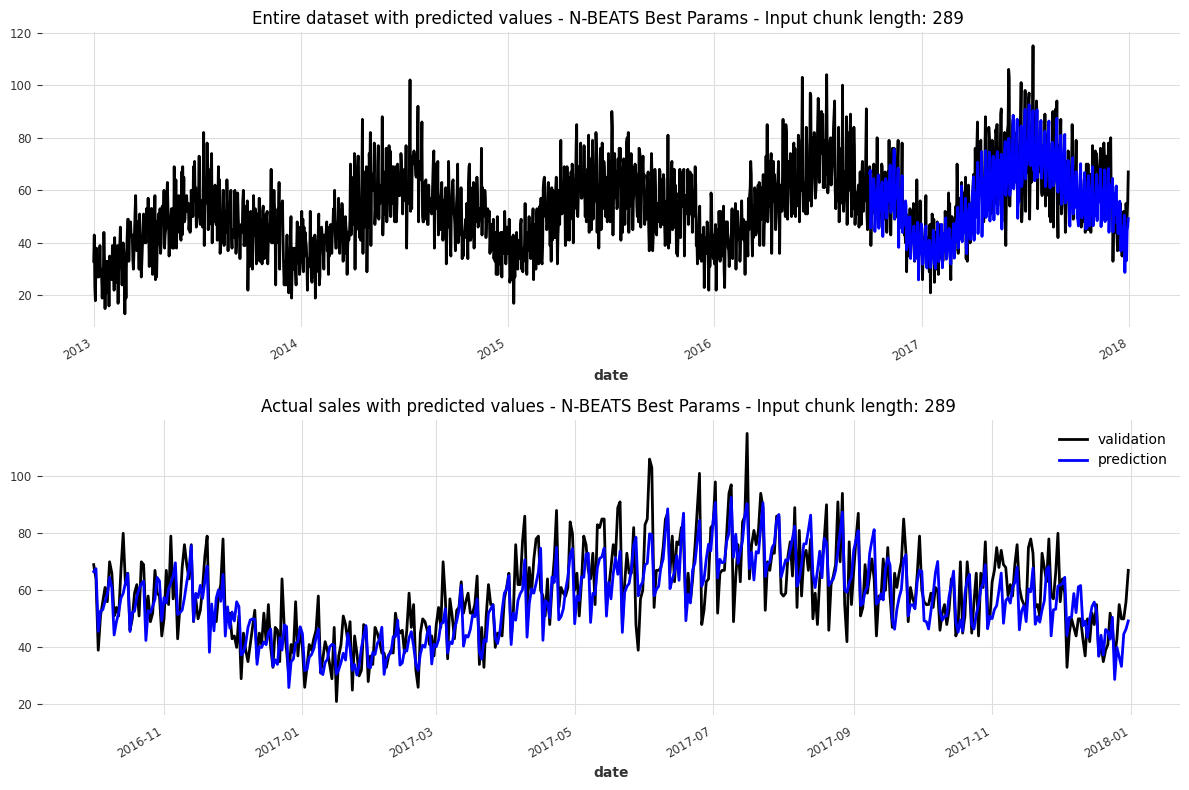

In [63]:
RUN_N_BEATS_BEST_PARAMS = True #Flag to stop this acidentally running, takes 15 mins
if RUN_N_BEATS_BEST_PARAMS:
    model = NBEATSModel(input_chunk_length=study.best_trial.params['input_chunk_length'], output_chunk_length=30, random_state=42)
    model.fit([train_scaled], epochs=30, verbose=True)
    pred = model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)

    plot_training_val(entire_series = single_series, 
                pred = pred, 
                val = val, 
                model_name = f"N-BEATS Best Params - Input chunk length: {study.best_trial.params['input_chunk_length']} ")
    
    results_dict['N-BEATS_best_params'] = smape(single_series, pred)

# Results Visualization 

Let's compare the results of the various algorithms. 

Text(0.5, 0, 'SMAPE Value')

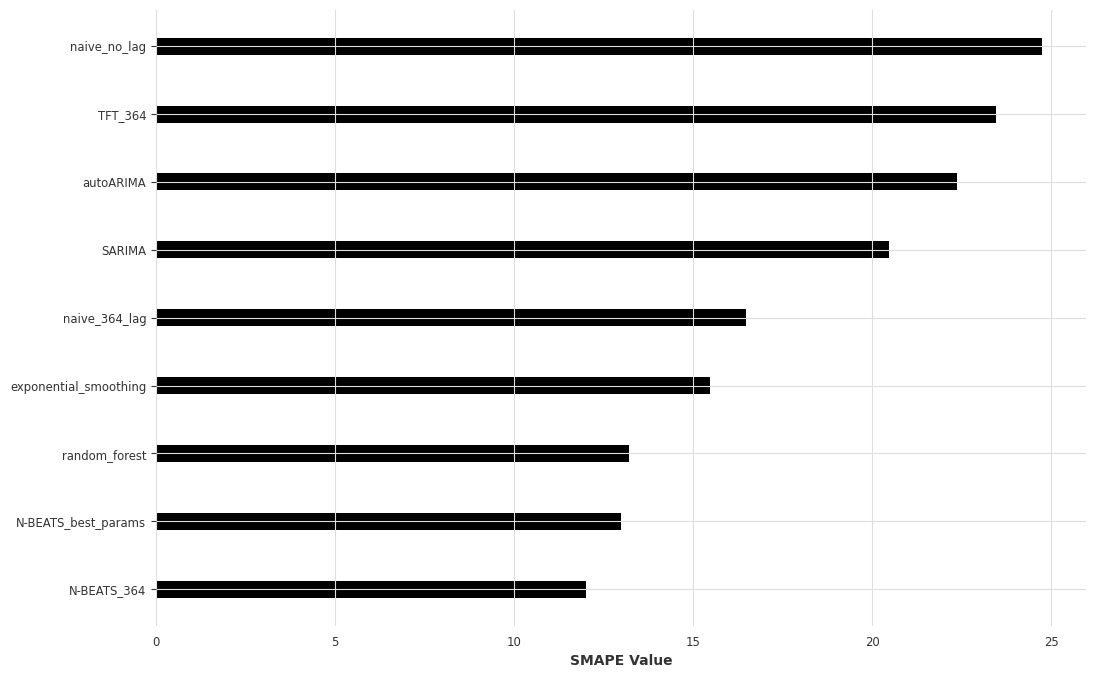

In [64]:
results_dict_sorted = {k: v for k, v in sorted(results_dict.items(), key=lambda item: item[1])}
fig, ax = plt.subplots(figsize = (12,8))
ax.barh(list(results_dict_sorted.keys()), list(results_dict_sorted.values()),height = 0.25)
ax.set_xlabel("SMAPE Value")